# What have been done

**Before making changes, make copy of this colab, so we wan't loose working notebook**.

I’ve finished the data preprocessing and added several new engineered features, making the dataset ready for model training. At this stage, everyone should be able to train any model they want using the prepared data. I’m still not completely certain that all missing values and imputations were handled optimally, but overall the per-person clustering results look solid and appear to capture meaningful glucose behavior patterns.

Currently, the code works on data from a single person for simplicity. To run it, you need to zip the folder containing persons **CGM records** (upload the folder itself, not the root archive) and then run all cells in the notebook. For the first test case (subject 9), I identified eight clusters representing different glucose dynamics. I have only interpreted the most obvious clusters so far, but the approach seems effective.

## Plan
1. We will first combine all subjects’ data into a single dataset, including subject IDs, and normalize features per person to remove baseline differences while preserving personal glucose patterns. Clustering will be run per person using UMAP + DBSCAN to identify individualized glucose-behavior patterns (Or maybe we will need make it globally, TBD). When all participants are included, the number of clusters may change depending on how patterns overlap. Each cluster will then be interpreted physiologically, possibly with input from the project owner or literature. If clusters are less separable, we can tune UMAP/DBSCAN, engineer new features, or clean up noisy data. (Paul, this is your task.)
    - TODO Paul (ja Mykyta): 1. try clustering with other people 2. try to translate what each cluster means for a person 3. label data

2. Next, we will build glucose forecasting models. Tree-based models such as Decision Trees, Random Forest, or Gradient Boosting (XGBoost) are a simple starting point. They predict a single future CGM value and provide feature importance scores, helping to understand which factors drive glucose changes. While usually single-step, they can be extended to multi-step predictions.

For more advanced modeling, we will use sequence-based approaches like LSTM, GRU, 1D CNN, or Transformers, which can predict a full trajectory of future glucose values and capture longer-term temporal patterns. Classical time-series models like ARIMA or Prophet can also be used to capture trends and seasonality. These models allow us to forecast not only the “what” future glucose, but also gain insight into the “why” by identifying influential features and patterns. (Henri and Jense, this is your task; ARIMA seems for me is a good starting point, but check what others have used.)

For models split the data by the subject ID, not randomly, to avoid data leakage.

TIPS: we can get more precise clusters labels if we devide also data per person by time of the year. Like by quaters. Maybe it's different.

# Dataset overview

First and foremost, let's download data to the project. Upload only CGM records (folder where are inside csv files with data). Before uloading zip it.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving CGM Records.zip to CGM Records (2).zip
User uploaded file "CGM Records (2).zip" with length 1538119 bytes


In [ ]:
!unzip CGM\ Records.zip

Archive:  CGM Records.zip
replace CGM Records/Subject 5/Subject 5.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Each Subject folder contains data from a different person. Let's take a look at how this data looks using one person's data as an example.

In [114]:
import pandas as pd
import os

subject_folders = [f for f in os.listdir('CGM Records') if os.path.isdir(os.path.join('CGM Records', f))]

if subject_folders:
  first_subject_folder = subject_folders[0]
  csv_file_path = os.path.join('CGM Records', first_subject_folder, f'{first_subject_folder}.csv')

  try:
    df = pd.read_csv(csv_file_path, parse_dates=["EventDateTime"])
  except FileNotFoundError:
    print(f"Error: The file {csv_file_path} was not found.")
  except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")

else:
  print("No subject folders found in 'CGM Records'.")

df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11042 entries, 0 to 11041
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   EventDateTime               11042 non-null  datetime64[ns]
 1   DeviceMode                  0 non-null      float64       
 2   BolusType                   593 non-null    object        
 3   Basal                       7419 non-null   float64       
 4   CorrectionDelivered         593 non-null    float64       
 5   TotalBolusInsulinDelivered  593 non-null    float64       
 6   FoodDelivered               593 non-null    float64       
 7   CarbSize                    593 non-null    float64       
 8   CGM                         11042 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 776.5+ KB


,EventDateTime,DeviceMode,BolusType,Basal,CorrectionDelivered,TotalBolusInsulinDelivered,FoodDelivered,CarbSize,CGM
0,2023-12-08 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151
1,2023-12-08 00:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152
2,2023-12-08 00:14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156
3,2023-12-08 00:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158
4,2023-12-08 00:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160
...,...,...,...,...,...,...,...,...,...
11037,2024-01-15 23:34:00,NaN,NaN,0.966,NaN,NaN,NaN,NaN,93
11038,2024-01-15 23:39:00,NaN,NaN,0.966,NaN,NaN,NaN,NaN,93
11039,2024-01-15 23:44:00,NaN,NaN,0.966,NaN,NaN,NaN,NaN,93
11040,2024-01-15 23:49:00,NaN,NaN,0.966,NaN,NaN,NaN,NaN,94



The AZT1D dataset consists of multiple records per participant, capturing real-world diabetes management data, including CGM readings, insulin administration events, and carbohydrate intake. Each record contains the following fields:

*   **EventDateTime**: The timestamp indicating when the event was recorded.
*   **DeviceMode**: The operating mode of the insulin pump at the time of the event, such as regular, sleep, or exercise.
*   **BolusType**: The type of bolus insulin delivered, including standard, correction, or automatic boluses.
*   **Basal**: The amount of basal insulin (in units) delivered continuously over time.
*   **CorrectionDelivered**: The portion of the bolus insulin administered to correct high blood glucose levels.
*   **TotalBolusInsulinDelivered**: The total insulin dose (in units) administered during a bolus event.
*   **FoodDelivered**: The portion of the bolus insulin dedicated to covering meal carbohydrate intake.
*   **CarbSize**: The amount of carbohydrates consumed, measured in grams.
*   **CGM**: The recorded glucose value from the continuous glucose monitoring device, measured in mg/dL.

Here is the description by ChatGPT of each field who isn't familiar with diabetes terms

1. EventDateTime

This field records the exact date and time when an event occurred. Events can include a new glucose measurement, an insulin dose, or the recording of a meal. The timestamp allows researchers to analyze how glucose levels vary over time and how they respond to specific actions, such as eating or administering insulin.

2. DeviceMode

This indicates the operating mode of the insulin pump when the event was recorded.

Common modes include:
* Regular mode: Standard daily operation.
* Sleep mode: A mode used during sleep, which may reduce insulin delivery to prevent low blood sugar at night.
* Exercise mode: A setting that temporarily adjusts insulin delivery to account for physical activity, which can lower blood sugar levels.

Understanding the device mode helps explain patterns in glucose fluctuations and insulin usage under different daily conditions.

3. BolusType

This describes the type of bolus insulin dose delivered. A bolus is a single, larger insulin dose given to manage blood sugar spikes, usually after eating or to correct high glucose levels.
Typical bolus types include:

* Standard: A single insulin dose given immediately.

* Correction: A dose given to bring down a high glucose level.

* Automatic or extended bolus: A dose spread over time or delivered automatically by an advanced insulin pump.

This field helps distinguish between insulin given for meals versus insulin given to correct elevated glucose levels.

4. Basal

This represents the continuous, background insulin delivered by the pump, measured in insulin units. Unlike bolus doses, basal insulin is provided steadily throughout the day and night to maintain normal blood glucose between meals and during sleep. It is a key factor in long-term glucose control.

5. CorrectionDelivered

This field shows the portion of a bolus that was specifically intended to correct high blood glucose. It helps separate insulin used for corrections from insulin used for food coverage, which is important for analyzing how different insulin types affect glucose levels.

6. TotalBolusInsulinDelivered

This is the total amount of insulin (in units) delivered in a single bolus event. It includes all types of bolus insulin—both for food and for correction. This value provides an overview of total short-term insulin delivery at each event.

7. FoodDelivered

This field records the amount of bolus insulin administered to cover carbohydrate intake from meals or snacks. It reflects the insulin required to process food and maintain glucose levels after eating.

8. CarbSize

This indicates the amount of carbohydrates consumed, measured in grams. Carbohydrates are the main nutrient that raises blood glucose levels after eating. When analyzed alongside FoodDelivered and CGM data, CarbSize helps assess how well insulin doses match carbohydrate intake.

9. CGM

This field contains glucose readings from the continuous glucose monitoring (CGM) device, measured in milligrams per deciliter (mg/dL). The CGM provides near-continuous tracking of glucose levels throughout the day, typically recording every five minutes. These readings show how glucose changes in response to meals, insulin, exercise, and other factors.

In [ ]:
print(df["DeviceMode"].isna().sum())

11042


There are days when Device Mode and Basal values are empty. We still consider those days for better understanding patterns. However, maybe we should impute some data or delete those days for predictive modeling

# Dataset pre-processing

In [115]:
df = df.sort_values('EventDateTime').reset_index(drop=True)

df

,EventDateTime,DeviceMode,BolusType,Basal,CorrectionDelivered,TotalBolusInsulinDelivered,FoodDelivered,CarbSize,CGM
0,2023-12-08 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151
1,2023-12-08 00:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152
2,2023-12-08 00:14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156
3,2023-12-08 00:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158
4,2023-12-08 00:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160
...,...,...,...,...,...,...,...,...,...
11037,2024-01-15 23:34:00,NaN,NaN,0.966,NaN,NaN,NaN,NaN,93
11038,2024-01-15 23:39:00,NaN,NaN,0.966,NaN,NaN,NaN,NaN,93
11039,2024-01-15 23:44:00,NaN,NaN,0.966,NaN,NaN,NaN,NaN,93
11040,2024-01-15 23:49:00,NaN,NaN,0.966,NaN,NaN,NaN,NaN,94


In [116]:
df['DeviceMode'] = df['DeviceMode'].fillna('Unknown')
df['BolusType'] = df['BolusType'].fillna('None')
for col in ['Basal', 'CorrectionDelivered', 'TotalBolusInsulinDelivered', 'FoodDelivered', 'CarbSize']:
    df[col] = df[col].fillna(0)

# Test that CGM is complete
if df['CGM'].isna().any():
    print("Warning: CGM contains NaNs — consider interpolating.")
    df['CGM'] = df['CGM'].interpolate(method='linear')
df

,EventDateTime,DeviceMode,BolusType,Basal,CorrectionDelivered,TotalBolusInsulinDelivered,FoodDelivered,CarbSize,CGM
0,2023-12-08 00:04:00,Unknown,None,0.000,0.0,0.0,0.0,0.0,151
1,2023-12-08 00:09:00,Unknown,None,0.000,0.0,0.0,0.0,0.0,152
2,2023-12-08 00:14:00,Unknown,None,0.000,0.0,0.0,0.0,0.0,156
3,2023-12-08 00:19:00,Unknown,None,0.000,0.0,0.0,0.0,0.0,158
4,2023-12-08 00:24:00,Unknown,None,0.000,0.0,0.0,0.0,0.0,160
...,...,...,...,...,...,...,...,...,...
11037,2024-01-15 23:34:00,Unknown,None,0.966,0.0,0.0,0.0,0.0,93
11038,2024-01-15 23:39:00,Unknown,None,0.966,0.0,0.0,0.0,0.0,93
11039,2024-01-15 23:44:00,Unknown,None,0.966,0.0,0.0,0.0,0.0,93
11040,2024-01-15 23:49:00,Unknown,None,0.966,0.0,0.0,0.0,0.0,94


# Feature Engineering

In [117]:
# Glucose rate of change (mg/dL per min)
df['CGM_diff'] = df['CGM'].diff() # CGM diff per 5 minutes
df['CGM_rate_mgdl_per_min'] = df['CGM_diff'] / 5 #CGM diff per minute

# Rolling statistics (30-min)
df['CGM_mean_30min'] = df['CGM'].rolling(window=6, min_periods=1).mean()
df['CGM_std_30min'] = df['CGM'].rolling(window=6, min_periods=1).std()

# Time-based features
df['hour'] = df['EventDateTime'].dt.hour
df['dayofweek'] = df['EventDateTime'].dt.dayofweek
df['is_night'] = df['hour'].between(0, 6).astype(int)
df['is_day'] = df['hour'].between(7, 22).astype(int)

# Time since last bolus / meal
df['has_bolus'] = (df['TotalBolusInsulinDelivered'] > 0).astype(int)
df['has_meal'] = (df['CarbSize'] > 0).astype(int)

df['minutes_since_last_bolus'] = (
    (df['EventDateTime'] - df['EventDateTime'].where(df['has_bolus']==1).ffill()).dt.total_seconds() / 60
)
df['minutes_since_last_meal'] = (
    (df['EventDateTime'] - df['EventDateTime'].where(df['has_meal']==1).ffill()).dt.total_seconds() / 60
)

# As majority of models can't handle NaN values in dataframe, we should fill all Nans with some value
# Because 0 can actually mean something in the real data, like that there is not difference between CGM
# we should add extra flags, so models can better understand when exactly this is real data, and when just mock data
df['has_previous_bolus'] = (~df['minutes_since_last_bolus'].isna()).astype(int)
df['has_previous_meal'] = (~df['minutes_since_last_meal'].isna()).astype(int)

df['CGM_rate_mgdl_per_min'] = df['CGM_rate_mgdl_per_min'].fillna(0)
df['minutes_since_last_bolus'] = df['minutes_since_last_bolus'].fillna(0)
df['minutes_since_last_meal'] = df['minutes_since_last_meal'].fillna(0)
df['CGM_diff'] = df['CGM_diff'].fillna(0)
df['CGM_std_30min'] = df['CGM_std_30min'].fillna(0)

df

,EventDateTime,DeviceMode,BolusType,Basal,CorrectionDelivered,TotalBolusInsulinDelivered,FoodDelivered,CarbSize,CGM,CGM_diff,CGM_rate_mgdl_per_min,CGM_mean_30min,CGM_std_30min,hour,dayofweek,is_night,is_day,has_bolus,has_meal,minutes_since_last_bolus,minutes_since_last_meal,has_previous_bolus,has_previous_meal
0,2023-12-08 00:04:00,Unknown,None,0.000,0.0,0.0,0.0,0.0,151,0.0,0.0,151.000000,0.000000,0,4,1,0,0,0,0.0,0.0,0,0
1,2023-12-08 00:09:00,Unknown,None,0.000,0.0,0.0,0.0,0.0,152,1.0,0.2,151.500000,0.707107,0,4,1,0,0,0,0.0,0.0,0,0
2,2023-12-08 00:14:00,Unknown,None,0.000,0.0,0.0,0.0,0.0,156,4.0,0.8,153.000000,2.645751,0,4,1,0,0,0,0.0,0.0,0,0
3,2023-12-08 00:19:00,Unknown,None,0.000,0.0,0.0,0.0,0.0,158,2.0,0.4,154.250000,3.304038,0,4,1,0,0,0,0.0,0.0,0,0
4,2023-12-08 00:24:00,Unknown,None,0.000,0.0,0.0,0.0,0.0,160,2.0,0.4,155.400000,3.847077,0,4,1,0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11037,2024-01-15 23:34:00,Unknown,None,0.966,0.0,0.0,0.0,0.0,93,-1.0,-0.2,96.333333,2.804758,23,0,0,0,0,0,230.0,230.0,1,1
11038,2024-01-15 23:39:00,Unknown,None,0.966,0.0,0.0,0.0,0.0,93,0.0,0.0,95.166667,2.401388,23,0,0,0,0,0,235.0,235.0,1,1
11039,2024-01-15 23:44:00,Unknown,None,0.966,0.0,0.0,0.0,0.0,93,0.0,0.0,94.166667,1.602082,23,0,0,0,0,0,240.0,240.0,1,1
11040,2024-01-15 23:49:00,Unknown,None,0.966,0.0,0.0,0.0,0.0,94,1.0,0.2,93.666667,0.816497,23,0,0,0,0,0,245.0,245.0,1,1


Take a look how CGM looking during the day

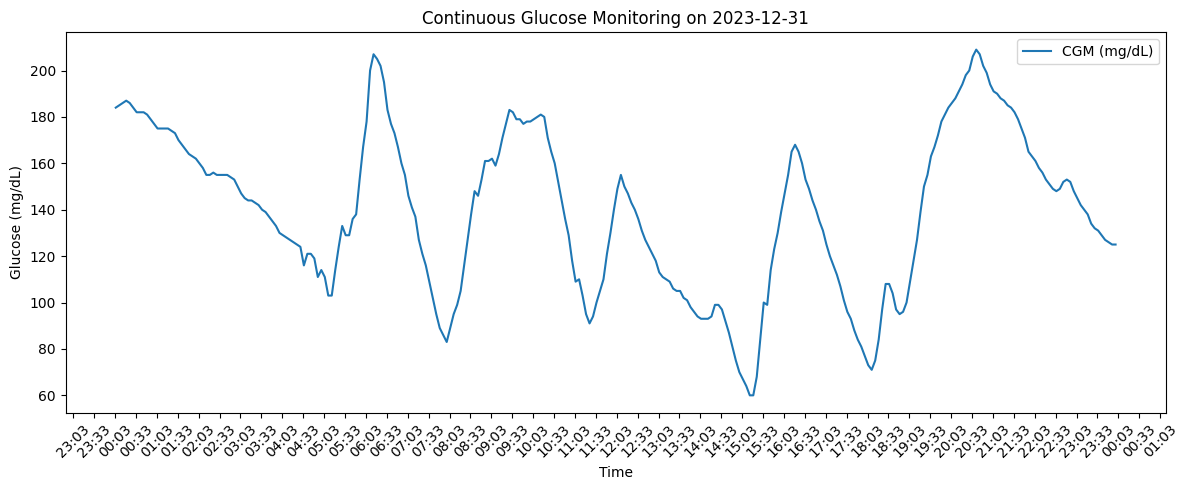

,EventDateTime,DeviceMode,BolusType,Basal,CorrectionDelivered,TotalBolusInsulinDelivered,FoodDelivered,CarbSize,CGM,CGM_diff,CGM_rate_mgdl_per_min,CGM_mean_30min,CGM_std_30min,hour,dayofweek,is_night,is_day,has_bolus,has_meal,minutes_since_last_bolus,minutes_since_last_meal,has_previous_bolus,has_previous_meal
6440,2023-12-31 00:04:00,Unknown,None,2.349,0.00,0.00,0.0,0.0,184,-2.0,-0.4,188.000000,2.607681,0,6,1,0,0,0,50.0,540.0,1,1
6441,2023-12-31 00:09:00,Unknown,None,2.349,0.00,0.00,0.0,0.0,185,1.0,0.2,187.000000,2.366432,0,6,1,0,0,0,55.0,545.0,1,1
6442,2023-12-31 00:14:00,Unknown,None,2.349,0.00,0.00,0.0,0.0,186,1.0,0.2,186.333333,1.861899,0,6,1,0,0,0,60.0,550.0,1,1
6443,2023-12-31 00:19:00,Unknown,Automatic Bolus/Correction,2.349,3.18,3.18,0.0,0.0,187,1.0,0.2,186.000000,1.414214,0,6,1,0,1,0,0.0,555.0,1,1
6444,2023-12-31 00:24:00,Unknown,None,2.349,0.00,0.00,0.0,0.0,186,-1.0,-0.2,185.666667,1.032796,0,6,1,0,0,0,5.0,560.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6723,2023-12-31 23:39:00,Unknown,None,2.017,0.00,0.00,0.0,0.0,129,-2.0,-0.4,134.000000,4.242641,23,6,0,0,0,0,160.0,300.0,1,1
6724,2023-12-31 23:44:00,Unknown,None,2.017,0.00,0.00,0.0,0.0,127,-2.0,-0.4,131.833333,3.868678,23,6,0,0,0,0,165.0,305.0,1,1
6725,2023-12-31 23:49:00,Unknown,None,2.017,0.00,0.00,0.0,0.0,126,-1.0,-0.2,129.833333,3.060501,23,6,0,0,0,0,170.0,310.0,1,1
6726,2023-12-31 23:54:00,Unknown,None,2.017,0.00,0.00,0.0,0.0,125,-1.0,-0.2,128.333333,2.804758,23,6,0,0,0,0,175.0,315.0,1,1


In [118]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter data for a specific day
target_date = '2023-12-31'
one_day_df = df[df['EventDateTime'].dt.date == pd.to_datetime(target_date).date()]

plt.figure(figsize=(12,5))
plt.plot(one_day_df['EventDateTime'], one_day_df['CGM'], label='CGM (mg/dL)', linewidth=1.5)
plt.title(f'Continuous Glucose Monitoring on {target_date}')
plt.xlabel('Time')
plt.ylabel('Glucose (mg/dL)')
plt.legend()

ax = plt.gca()
formatter = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)
locator = mdates.MinuteLocator(interval=30)
ax.xaxis.set_major_locator(locator)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

display(one_day_df)

In [ ]:
# df = df.set_index('EventDateTime')
# print(df.head(10))

Let's now check for any remaining NaN values in the DataFrame. If there is 0 in each column, then it's good, we can continue.

In [119]:
nan_count_by_columns = df.isnull().sum()
if nan_count_by_columns.sum() > 0:
  print("Warning: There are still NaN values in the dataset. Check dataset correctness.")
  display(nan_count_by_columns[nan_count_by_columns > 0])
else:
  print("No NaN values found in the dataset.")

No NaN values found in the dataset.


# Pattern detection

In this section we will start to detect patterns by using UMAP to reduce demintionality and then DBSCAN to detect clusters.

In [122]:
feature_cols = [
    'CGM', 'CGM_diff', 'CGM_rate_mgdl_per_min', 'CGM_mean_30min', 'CGM_std_30min',
    'TotalBolusInsulinDelivered', 'CorrectionDelivered', 'FoodDelivered', 'CarbSize',
    'minutes_since_last_bolus', 'minutes_since_last_meal',
    'has_previous_bolus', 'has_previous_meal',
    'hour', 'is_night'
]

X = df[feature_cols].copy()


As UMAP and DBSCAN are sensitive to value scale because they use those values to caclulate distances, we should use some scaler

In [121]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from umap import UMAP

umap_model = UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
# umap_model = UMAP(n_components=3, n_neighbors=30, min_dist=0.1)
X_umap = umap_model.fit_transform(X_scaled)

df['UMAP1'] = X_umap[:,0]
df['UMAP2'] = X_umap[:,1]
# df['UMAP3'] = X_umap[:,2]

It's for 3D demension

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111, projection='3d')

# scatter = ax.scatter(df['UMAP1'], df['UMAP2'], df['UMAP3'], c=df['CGM'], cmap='viridis', s=5)

# ax.set_xlabel('UMAP1')
# ax.set_ylabel('UMAP2')
# ax.set_zlabel('UMAP3')
# ax.set_title('3D UMAP Projection of Glucose + Insulin Features')

# cbar = fig.colorbar(scatter, pad=0.1)
# cbar.set_label('CGM (mg/dL)')

# plt.show()

In [131]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, random_state=42)
labels = gmm.fit_predict(X)

df['GMM_Cluster'] = labels

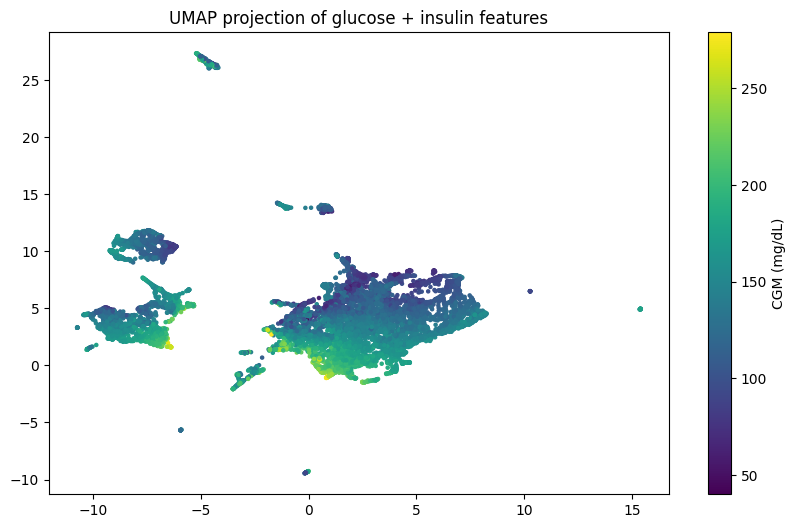

In [130]:
plt.figure(figsize=(10,6))
plt.scatter(df['UMAP1'], df['UMAP2'], c=df['CGM'], cmap='viridis', s=5)
plt.colorbar(label='CGM (mg/dL)')
plt.title('UMAP projection of glucose + insulin features')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10) # eps to tune
clusters = dbscan.fit_predict(X_umap)

df['cluster'] = clusters

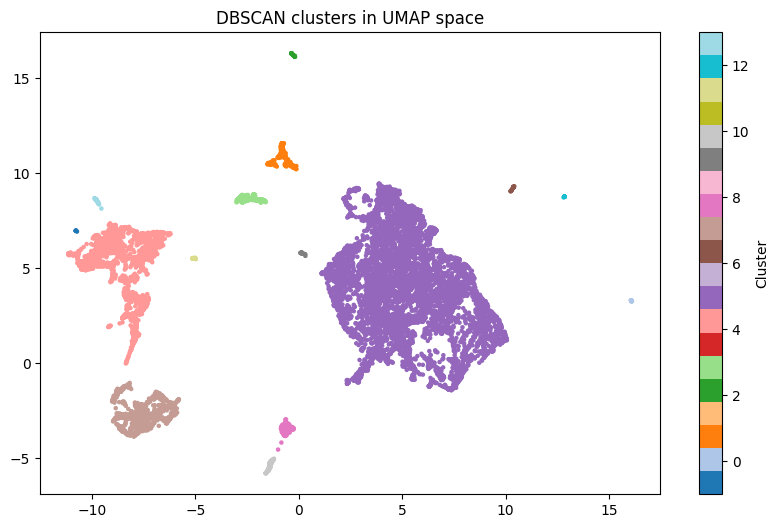

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df['UMAP1'], df['UMAP2'], c=df['cluster'], cmap='tab20', s=5)
plt.colorbar(label='Cluster')
plt.title('DBSCAN clusters in UMAP space')
plt.show()

In [136]:
import seaborn as sns

def plot_cluster_analysis(df, cluster_col):
    # Cluster distribution
    cluster_counts = df[cluster_col].value_counts().sort_index()
    plt.figure(figsize=(8,4))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
    plt.title("Cluster distribution")
    plt.xlabel("Cluster")
    plt.ylabel("Number of samples")
    plt.show()

    # Median CGM over 24-hour clock for each cluster
    plt.figure(figsize=(12,6))
    for cl in sorted(df[cluster_col].unique()):
        hourly_pattern = (
            df[df[cluster_col] == cl]
            .groupby('hour')['CGM']
            .median()
            .reset_index()
        )
        plt.plot(hourly_pattern['hour'], hourly_pattern['CGM'], label=f"Cluster {cl}")
    plt.title("Median CGM across 24h per cluster")
    plt.xlabel("Hour of day")
    plt.ylabel("Median CGM (mg/dL)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # # UMAP scatter by cluster
    # plt.figure(figsize=(10,6))
    # sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='cluster', palette='tab20', s=8)
    # plt.title("UMAP projection colored by cluster")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.show()

    # CGM histogram by cluster
    plt.figure(figsize=(12,6))
    for cl in sorted(df[cluster_col].unique()):
        sns.kdeplot(df[df[cluster_col]==cl]['CGM'], label=f"Cluster {cl}")
    plt.title("Distribution of CGM values by cluster")
    plt.xlabel("CGM (mg/dL)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Focused visualization: clusters 3 and 7
    focus_clusters = [3,7]
    plt.figure(figsize=(12,6))
    for cl in focus_clusters:
        hourly_pattern = (
            df[df[cluster_col] == cl]
            .groupby('hour')['CGM']
            .median()
            .reset_index()
        )
        plt.plot(hourly_pattern['hour'], hourly_pattern['CGM'], marker='o', label=f"Cluster {cl}")
    plt.title("Clusters 3 & 7 - Median CGM pattern by time of day")
    plt.xlabel("Hour of day")
    plt.ylabel("Median CGM (mg/dL)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Cluster-level summary table
    summary_cols = ['CGM','CGM_diff','CGM_rate_mgdl_per_min','TotalBolusInsulinDelivered',
                    'FoodDelivered','CarbSize','minutes_since_last_bolus','minutes_since_last_meal',
                    'hour','is_night']
    cluster_summary = df.groupby(cluster_col)[summary_cols].median().round(2)
    display(cluster_summary)


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\719030589.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


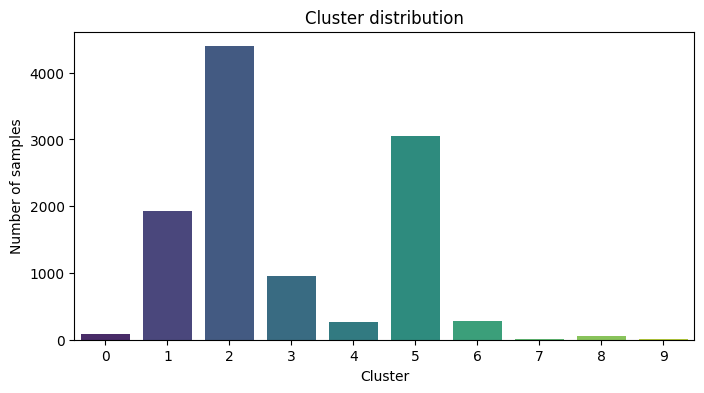

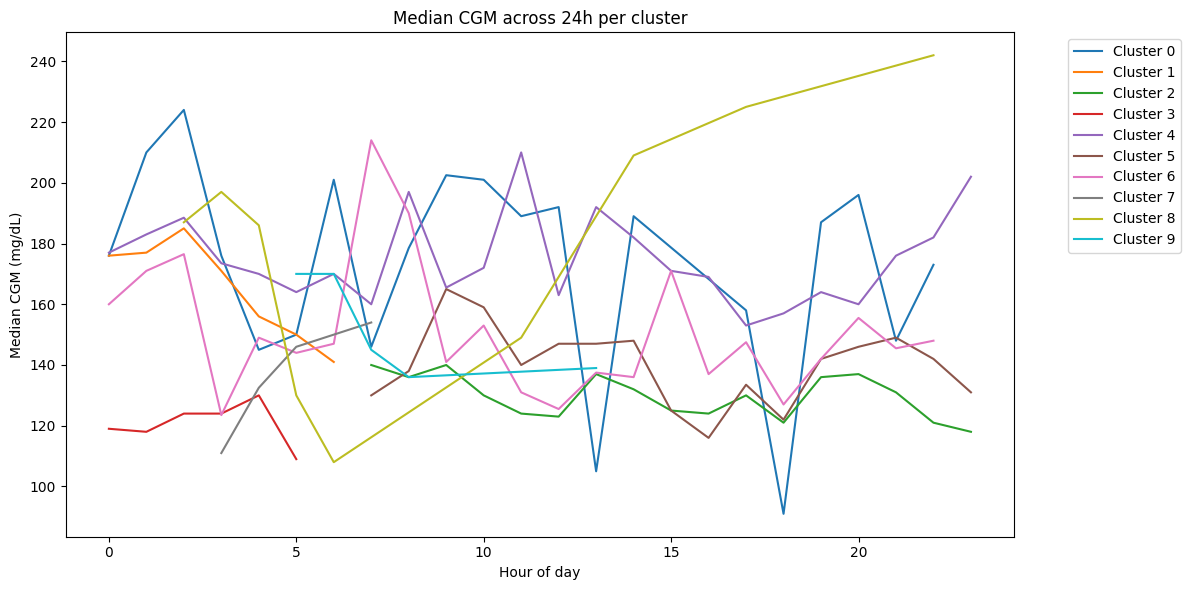

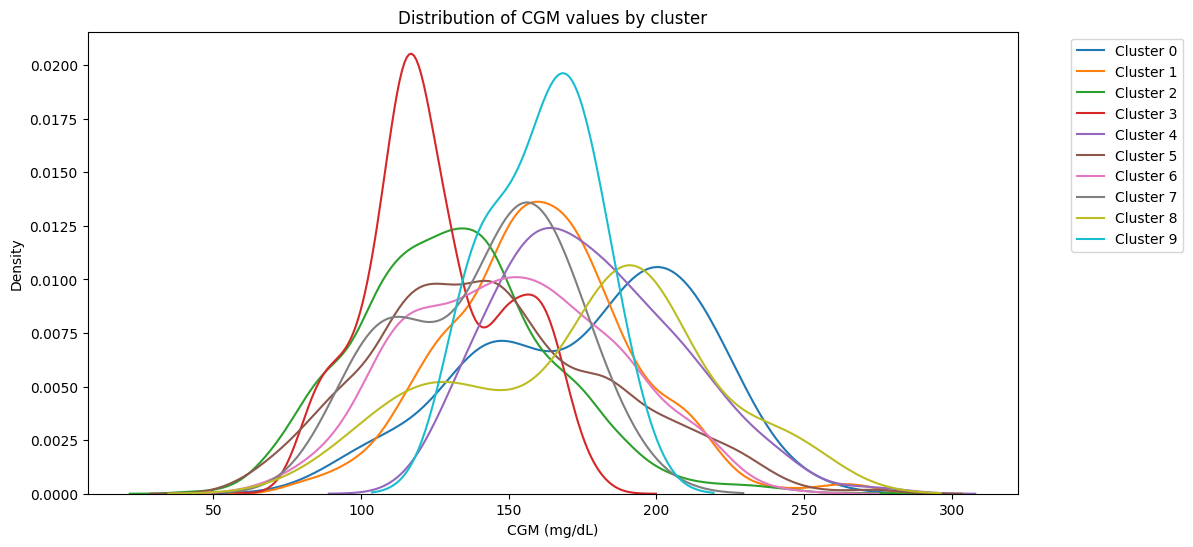

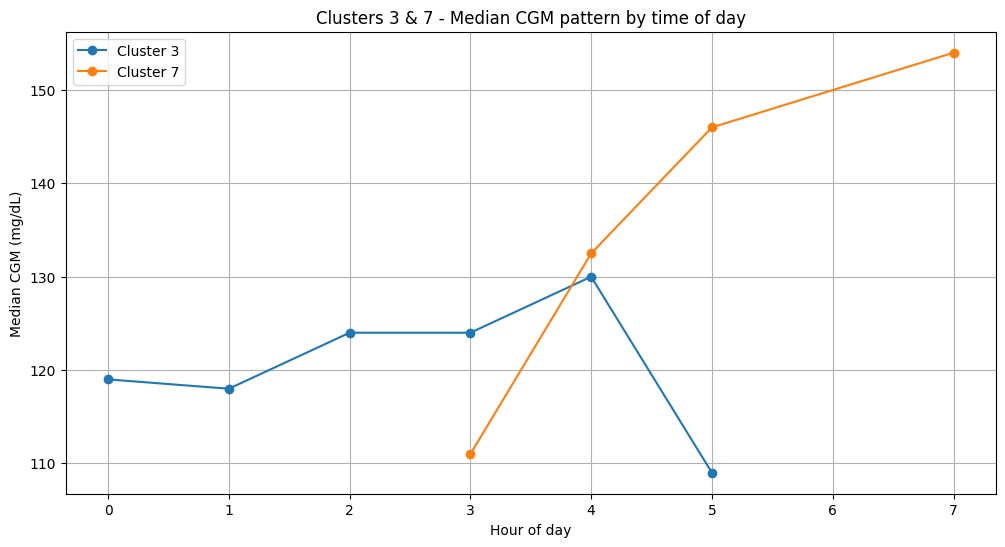

,CGM,CGM_diff,CGM_rate_mgdl_per_min,TotalBolusInsulinDelivered,FoodDelivered,CarbSize,minutes_since_last_bolus,minutes_since_last_meal,hour,is_night
GMM_Cluster,,,,,,,,,,
0,188.0,0.0,0.0,4.00,0.0,0.0,0.0,105.0,4.0,1.0
1,160.0,0.0,0.0,0.00,0.0,0.0,50.0,490.0,4.0,1.0
2,130.0,0.0,0.0,0.00,0.0,0.0,80.0,80.0,15.0,0.0
3,121.0,1.0,0.2,0.00,0.0,0.0,355.0,405.0,1.0,1.0
4,174.0,0.0,0.0,5.34,0.0,0.0,0.0,245.0,9.0,0.0
5,142.0,-1.0,-0.2,0.00,0.0,0.0,65.0,240.0,15.0,0.0
6,150.0,0.0,0.0,11.20,10.0,30.0,0.0,0.0,11.0,0.0
7,154.0,1.0,0.2,0.00,0.0,0.0,10.0,580.0,4.0,1.0
8,186.0,-1.0,-0.2,0.00,0.0,0.0,25.0,0.0,4.0,1.0


In [137]:
plot_cluster_analysis(df, 'GMM_Cluster')

In [ ]:
selected_clusters = [3, 4, 5, 7]
display(cluster_summary.loc[selected_clusters])

,CGM,CGM_diff,CGM_rate_mgdl_per_min,TotalBolusInsulinDelivered,FoodDelivered,CarbSize,minutes_since_last_bolus,minutes_since_last_meal,hour,is_night
cluster,,,,,,,,,,
3,142.0,0.0,0.0,11.67,10.0,35.0,0.0,0.0,14.0,0.0
4,159.0,0.0,0.0,0.00,0.0,0.0,50.0,475.0,4.0,1.0
5,135.0,0.0,0.0,0.00,0.0,0.0,70.0,135.0,15.0,0.0
7,120.0,1.0,0.2,0.00,0.0,0.0,360.0,410.0,1.0,1.0


In [ ]:
rename_mapping = {
    'CGM_rate_mgdl_per_min': 'CGM_Rate',
    'TotalBolusInsulinDelivered': 'TotalBolus',
    'CorrectionDelivered': 'Correction',
    'FoodDelivered': 'Food',
    'CarbSize': 'Carbs',
    'minutes_since_last_bolus': 'MinLastBolus',
    'minutes_since_last_meal': 'MinLastMeal',
    'has_previous_bolus': 'PrevBolusFlag',
    'has_previous_meal': 'PrevMealFlag',
    'is_night': 'Night'
}

# Apply renaming to the cluster_summary DataFrame
cluster_summary_short_labels = cluster_summary.rename(columns=rename_mapping)

# Display the table with new, shorter labels for selected clusters
selected_clusters = [3, 4, 5, 7] # Assuming user still wants to see these clusters
display(cluster_summary_short_labels.loc[selected_clusters])

,CGM,CGM_diff,CGM_Rate,TotalBolus,Food,Carbs,MinLastBolus,MinLastMeal,hour,Night
cluster,,,,,,,,,,
3,142.0,0.0,0.0,11.67,10.0,35.0,0.0,0.0,14.0,0.0
4,159.0,0.0,0.0,0.00,0.0,0.0,50.0,475.0,4.0,1.0
5,135.0,0.0,0.0,0.00,0.0,0.0,70.0,135.0,15.0,0.0
7,120.0,1.0,0.2,0.00,0.0,0.0,360.0,410.0,1.0,1.0


In [ ]:
import matplotlib.pyplot as plt

selected_clusters = [3, 4, 5, 7]
selected_clusters_df = cluster_summary_short_labels.loc[selected_clusters]

fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('off')

table = ax.table(cellText=selected_clusters_df.values,
                 colLabels=selected_clusters_df.columns, # Corrected: use .columns
                 rowLabels=selected_clusters_df.index,
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) # Adjust overall table size

plt.savefig('cluster_summary_clusters_4_5_7_short_labels.png', bbox_inches='tight', dpi=300)
plt.close(fig) # Close the figure to prevent it from displaying in the notebook

print("Table saved as 'cluster_summary_clusters_4_5_7_short_labels.png'")

Table saved as 'cluster_summary_clusters_4_5_7_short_labels.png'


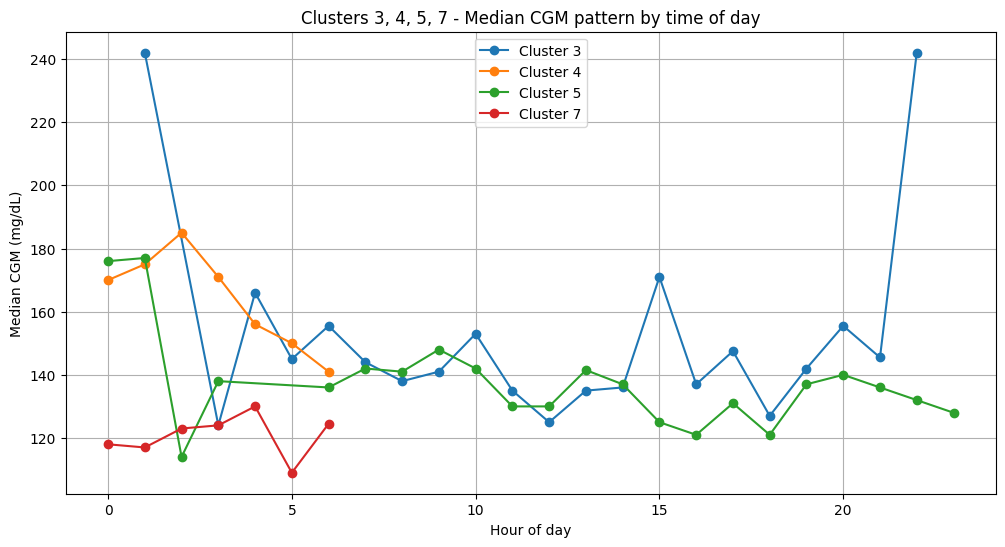

<Figure size 640x480 with 0 Axes>

In [ ]:
# Focused visualization: clusters 3 and 7
focus_clusters = [3,4,5,7]
plt.figure(figsize=(12,6))
for cl in focus_clusters:
    hourly_pattern = (
        df[df['cluster'] == cl]
        .groupby('hour')['CGM']
        .median()
        .reset_index()
    )
    plt.plot(hourly_pattern['hour'], hourly_pattern['CGM'], marker='o', label=f"Cluster {cl}")
plt.title("Clusters 3, 4, 5, 7 - Median CGM pattern by time of day")
plt.xlabel("Hour of day")
plt.ylabel("Median CGM (mg/dL)")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('cluster_summary_clusters_4_5_7.png', bbox_inches='tight', dpi=300)

As we can see, clusters 3 and 7 are the biggest. Here I think we need to speak with project owner, but here is interpretation from ChatGPT because i dunno what does each mean xD.

**Cluster 3 — likely “Post-meal hyperglycemia” or “daytime elevated stable”**

* High CGM (198 mg/dL) → moderate-to-high glucose levels.

* Stable (diff ≈ 0, rate ≈ 0) → not currently rising or falling rapidly.

* No recent insulin or carbs → suggests late post-meal or mild sustained hyperglycemia.

* mnutes_since_last_meal ≈ 220 (≈ 3.5 h) → meal was some time ago; glucose hasn’t normalized yet.

* hour = 15 (afternoon) → likely daytime.

Interpretation:
This looks like a post-meal plateau — glucose rose earlier and remains somewhat elevated even hours later, perhaps due to insulin under-dosing or delayed absorption.


---

**Cluster 7 — likely “Overnight mild hyperglycemia”**

* CGM = 165 mg/dL → moderate glucose.

* CGM_diff = -1 → slow decline.

* No carbs or bolus, hours since last meal ≈ 410 (~7 h) → long fasting period.

* Nighttime (hour = 3, is_night = 1) → overnight.

Interpretation:
This is probably nighttime stable or slightly declining high glucose — common if basal insulin is set a bit too low or if correction insulin wasn’t active overnight.


# Pre-processing of DiaTrend dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
!unzip diatrend.zip -d diatrend_extracted

Let's do some basic pre-processing and merge all the info known about each subject to each subject's seperate dataframe

In [3]:
import pandas as pd
import os
import re
import numpy as np

pattern = re.compile(r'Subject(\d{1,2})\.xlsx')

DIATREND_FOLDER = "diatrend"

demographic_df = pd.read_excel(f"{DIATREND_FOLDER}/SubjectDemographics_Feb2025.xlsx")

subjects = [f for f in os.listdir(DIATREND_FOLDER) if pattern.search(f)]
assert len(subjects) == 54, "Some subjects are missing"

subjects_dict = {}

for subject_file in subjects:
  print(f"Searching {subject_file}")
  match = pattern.search(subject_file)
  subject_id = int(match.group(1)) if match else None
  cgm_df = pd.read_excel(f"{DIATREND_FOLDER}/{subject_file}", sheet_name="CGM")
  cgm_df['date'] = cgm_df['date'].dt.floor('5min')
  cgm_df = cgm_df.groupby('date').agg({'mg/dl': 'mean'})

  bolus_df = pd.read_excel(f"{DIATREND_FOLDER}/{subject_file}", sheet_name="Bolus")
  bolus_df['date'] = bolus_df['date'].dt.floor('5min')

  agg_dict = {
    'normal': 'sum',
    'carbInput': 'sum',
    'insulinCarbRatio': 'mean',
    'bgInput': 'last',
    'recommended.carb': 'sum',
    'recommended.net': 'sum',
    'recommended.correction': 'sum',
    'insulinSensitivityFactor': 'mean',
    'targetBloodGlucose': 'mean',
    'insulinOnBoard': 'last'
  }

  filtered_agg_dict = {col: agg_func for col, agg_func in agg_dict.items() if col in bolus_df.columns}
  bolus_df = bolus_df.groupby('date').agg(filtered_agg_dict)

  subject_df = cgm_df.merge(
    bolus_df,
    how='left',
    on='date',
  )

  if not "insulinOnBoard" in bolus_df.columns:
    subject_df['has_bolus_metadata_extended'] = 0
  else:
    subject_df['has_bolus_metadata_extended'] = 1
  subject_df['basal_rate'] = 0
  subject_df['has_basal_data'] = 0

  try:
    basal_df = pd.read_excel(f"{DIATREND_FOLDER}/{subject_file}", sheet_name="Basal")
    basal_df['end_time'] = basal_df['date'] + pd.to_timedelta(basal_df['duration'], unit='ms')
    subject_df['has_basal_data'] = 1

    for _, row in basal_df.iterrows():
        mask = (subject_df.index >= row['date']) & (subject_df.index < row['end_time'])
        subject_df.loc[mask, 'basal_rate'] = row['rate']

    subject_df['basal_rate'] = subject_df['basal_rate'].ffill()

  except ValueError as e:
    print(f"{subject_file} missing basal info")

  subjects_dict[subject_id] = subject_df
  # break # REMOVE IF YOU WANNA GET ALL DATAFRAMES PER EACH SUBJECT - TAKES TIME TO RUN

Searching Subject1.xlsx
Subject1.xlsx missing basal info
Searching Subject10.xlsx
Subject10.xlsx missing basal info
Searching Subject11.xlsx
Subject11.xlsx missing basal info
Searching Subject12.xlsx
Subject12.xlsx missing basal info
Searching Subject13.xlsx
Subject13.xlsx missing basal info
Searching Subject14.xlsx
Subject14.xlsx missing basal info
Searching Subject15.xlsx
Subject15.xlsx missing basal info
Searching Subject16.xlsx
Subject16.xlsx missing basal info
Searching Subject17.xlsx
Subject17.xlsx missing basal info
Searching Subject18.xlsx
Subject18.xlsx missing basal info
Searching Subject19.xlsx
Subject19.xlsx missing basal info
Searching Subject2.xlsx
Subject2.xlsx missing basal info
Searching Subject20.xlsx
Subject20.xlsx missing basal info
Searching Subject21.xlsx
Subject21.xlsx missing basal info
Searching Subject22.xlsx
Subject22.xlsx missing basal info
Searching Subject23.xlsx
Subject23.xlsx missing basal info
Searching Subject24.xlsx
Subject24.xlsx missing basal info
S

C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\3596191242.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subject_df.loc[mask, 'basal_rate'] = row['rate']


Searching Subject3.xlsx
Subject3.xlsx missing basal info
Searching Subject30.xlsx
Searching Subject31.xlsx
Searching Subject32.xlsx
Subject32.xlsx missing basal info
Searching Subject33.xlsx
Subject33.xlsx missing basal info
Searching Subject34.xlsx
Subject34.xlsx missing basal info
Searching Subject35.xlsx
Subject35.xlsx missing basal info
Searching Subject36.xlsx


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\3596191242.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subject_df.loc[mask, 'basal_rate'] = row['rate']


Searching Subject37.xlsx
Searching Subject38.xlsx


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\3596191242.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subject_df.loc[mask, 'basal_rate'] = row['rate']


Searching Subject39.xlsx


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\3596191242.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subject_df.loc[mask, 'basal_rate'] = row['rate']


Searching Subject4.xlsx
Subject4.xlsx missing basal info
Searching Subject40.xlsx
Subject40.xlsx missing basal info
Searching Subject41.xlsx
Subject41.xlsx missing basal info
Searching Subject42.xlsx


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\3596191242.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subject_df.loc[mask, 'basal_rate'] = row['rate']


Searching Subject43.xlsx
Subject43.xlsx missing basal info
Searching Subject44.xlsx
Subject44.xlsx missing basal info
Searching Subject45.xlsx


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\3596191242.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7000000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subject_df.loc[mask, 'basal_rate'] = row['rate']


Searching Subject46.xlsx
Searching Subject47.xlsx


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\3596191242.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subject_df.loc[mask, 'basal_rate'] = row['rate']


Searching Subject48.xlsx
Subject48.xlsx missing basal info
Searching Subject49.xlsx
Searching Subject5.xlsx
Subject5.xlsx missing basal info
Searching Subject50.xlsx
Searching Subject51.xlsx


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\3596191242.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6000000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subject_df.loc[mask, 'basal_rate'] = row['rate']


Searching Subject52.xlsx
Searching Subject53.xlsx


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\3596191242.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.95' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subject_df.loc[mask, 'basal_rate'] = row['rate']


Searching Subject54.xlsx


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\3596191242.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subject_df.loc[mask, 'basal_rate'] = row['rate']


Searching Subject6.xlsx
Subject6.xlsx missing basal info
Searching Subject7.xlsx
Subject7.xlsx missing basal info
Searching Subject8.xlsx
Subject8.xlsx missing basal info
Searching Subject9.xlsx
Subject9.xlsx missing basal info


In [4]:
print(subject_df.index.min(), subject_df.index.max())

2019-04-09 11:50:00 2022-06-28 23:55:00


In [102]:
subject_df.columns

Index(['mg/dl', 'normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
       'recommended.carb', 'recommended.net', 'recommended.correction',
       'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard',
       'has_bolus_metadata_extended', 'basal_rate', 'has_basal_data'],
      dtype='object')

In [5]:
target_date = '2021-09-26 18'
data_for_date = subject_df.loc[target_date]

print(f"Data for {target_date}:")
display(data_for_date)

Data for 2021-09-26 18:


,mg/dl,normal,carbInput,insulinCarbRatio,bgInput,recommended.carb,recommended.net,recommended.correction,insulinSensitivityFactor,targetBloodGlucose,insulinOnBoard,has_bolus_metadata_extended,basal_rate,has_basal_data
date,,,,,,,,,,,,,,
2021-09-26 18:00:00,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2021-09-26 18:05:00,143.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2021-09-26 18:10:00,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2021-09-26 18:15:00,143.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2021-09-26 18:20:00,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2021-09-26 18:25:00,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2021-09-26 18:30:00,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2021-09-26 18:35:00,157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2021-09-26 18:40:00,163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0


Data is not continious. Even if we take CGM values as baseline, they are not available for each day.

In [6]:
subject_33_df = subjects_dict[33]
data_2019_2022 = subject_33_df[
    (subject_33_df.index.year >= 2019) &
    (subject_33_df.index.year <= 2022)
].copy()

data_2019_2022['date_only'] = data_2019_2022.index.floor('D')

min_day = data_2019_2022['date_only'].min()
max_day = data_2019_2022['date_only'].max()

full_days = pd.date_range(start=min_day, end=max_day, freq='D')
observed_days = pd.Index(data_2019_2022['date_only'].unique())

missing_days = full_days.difference(observed_days)

print(f"Checked days from {min_day.date()} to {max_day.date()}")
print("Missing_days")
missing_days


Checked days from 2021-07-13 to 2022-02-03
Missing_days


DatetimeIndex(['2021-08-09', '2021-08-10', '2021-08-11', '2021-08-22',
               '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
               '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12',
               '2021-09-13', '2021-09-14', '2021-09-15', '2021-10-25',
               '2021-10-26', '2021-10-27', '2021-10-28', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
               '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
      

# Feature engeneering

In [185]:
def engineer_features(df,
                      bolus_col='normal',
                      carb_col='carbInput',
                      bolus_window_min=4*60,        # 4 hours
                      carb_window_min=3*60,         # 3 hours
                      gap_minutes=15):

    df = df.copy()

    df = df.sort_index()
    df['gap'] = df.index.to_series().diff().dt.total_seconds().div(60).gt(gap_minutes)
    df['segment_id'] = df['gap'].cumsum()
    df.drop(columns=['gap'], inplace=True)

    df["slope_15min"] = (df["mg/dl"] - df["mg/dl"].shift(3)) / 15.0
    df["slope_30min"] = (df["mg/dl"] - df["mg/dl"].shift(6)) / 30.0
    df['mg/dl_diff'] = df['mg/dl'].diff().fillna(0)
    df['mg/dl_mean_30min'] = df['mg/dl'].rolling(window=6, min_periods=1).mean()
    df['mg/dl_std_30min']  = df['mg/dl'].rolling(window=6, min_periods=2).std().fillna(0)
    df['relative_mg/dl'] = df['mg/dl'] - df['mg/dl_mean_30min']

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_night'] = df['hour'].between(0, 6).astype(int)

    for col in [bolus_col, carb_col]:
        df[col] = df[col].fillna(0)

    def time_since_event_within_segment(g, event_col, max_minutes):
        last_event_time = g.index.to_series().where(g[event_col] > 0).ffill()
        minutes_since = (g.index - last_event_time).dt.total_seconds() / 60

        minutes_since = minutes_since.where(minutes_since <= max_minutes)

        return minutes_since

    df['minutes_since_last_bolus'] = (
        df.groupby('segment_id')
            .apply(lambda g: time_since_event_within_segment(g, bolus_col, bolus_window_min)) \
            .reset_index(level=0, drop=True).fillna(0)
    )
    df['bolus_active'] = (df["minutes_since_last_bolus"] < bolus_window_min).astype(int)

    df['minutes_since_last_meal'] = (
        df.groupby('segment_id')
            .apply(lambda g: time_since_event_within_segment(g, carb_col, carb_window_min)) \
            .reset_index(level=0, drop=True).fillna(0)
    )
    df['meal_active'] = (df["minutes_since_last_meal"] < carb_window_min).astype(int)

    extra_cols_zero = [
        'recommended.carb', 'recommended.net', 'recommended.correction',
        'insulinOnBoard', 'insulinCarbRatio', 'bgInput',
        'insulinSensitivityFactor', 'targetBloodGlucose'
    ]

    for col in extra_cols_zero:
        if col in df.columns:
            df[col] = df[col].fillna(0)
        else:
            df[col] = 0

    return df

In [145]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of text fields

In [186]:
subject_33_df_with_extra_features = engineer_features(subject_33_df)
display(subject_33_df_with_extra_features.isna().sum())
subject_33_df_with_extra_features


C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\1967320926.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: time_since_event_within_segment(g, bolus_col, bolus_window_min)) \
C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\1967320926.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: time_since_event_within_segment(g, carb_col, carb_window_min)) \


mg/dl                          0
normal                         0
carbInput                      0
insulinCarbRatio               0
bgInput                        0
recommended.carb               0
recommended.net                0
recommended.correction         0
insulinSensitivityFactor       0
targetBloodGlucose             0
insulinOnBoard                 0
has_bolus_metadata_extended    0
basal_rate                     0
has_basal_data                 0
segment_id                     0
slope_15min                    3
slope_30min                    6
mg/dl_diff                     0
mg/dl_mean_30min               0
mg/dl_std_30min                0
relative_mg/dl                 0
hour                           0
dayofweek                      0
is_night                       0
minutes_since_last_bolus       0
bolus_active                   0
minutes_since_last_meal        0
meal_active                    0
dtype: int64

,mg/dl,normal,carbInput,insulinCarbRatio,bgInput,recommended.carb,recommended.net,recommended.correction,insulinSensitivityFactor,targetBloodGlucose,insulinOnBoard,has_bolus_metadata_extended,basal_rate,has_basal_data,segment_id,slope_15min,slope_30min,mg/dl_diff,mg/dl_mean_30min,mg/dl_std_30min,relative_mg/dl,hour,dayofweek,is_night,minutes_since_last_bolus,bolus_active,minutes_since_last_meal,meal_active
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-13 19:50:00,213.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,NaN,NaN,0.0,213.000000,0.000000,0.000000,19,1,0,0.0,1,0.0,1
2021-07-13 19:55:00,227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,NaN,NaN,14.0,220.000000,9.899495,7.000000,19,1,0,0.0,1,0.0,1
2021-07-13 20:00:00,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,NaN,NaN,13.0,226.666667,13.503086,13.333333,20,1,0,0.0,1,0.0,1
2021-07-13 20:05:00,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2.600000,NaN,12.0,233.000000,16.792856,19.000000,20,1,0,0.0,1,0.0,1
2021-07-13 20:10:00,272.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,3.000000,NaN,20.0,240.800000,22.709029,31.200000,20,1,0,0.0,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-03 23:35:00,188.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30,0.666667,0.616667,1.5,179.833333,7.776032,8.666667,23,3,0,80.0,1,0.0,1
2022-02-03 23:40:00,188.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30,0.366667,0.650000,0.0,183.083333,6.272294,5.416667,23,3,0,85.0,1,0.0,1
2022-02-03 23:45:00,188.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30,0.100000,0.516667,0.0,185.666667,4.106905,2.833333,23,3,0,90.0,1,0.0,1


In [187]:
subject_33_df_with_extra_features[subject_33_df_with_extra_features['meal_active'] == 1]

# mask = (
# 	(subject_33_df_with_extra_features.index >= pd.to_datetime("2021-09-27 15:40")) &
# 	(subject_33_df_with_extra_features.index < pd.to_datetime("2021-09-27 20:00"))
# )
# subject_33_df_with_extra_features.loc[mask]

,mg/dl,normal,carbInput,insulinCarbRatio,bgInput,recommended.carb,recommended.net,recommended.correction,insulinSensitivityFactor,targetBloodGlucose,insulinOnBoard,has_bolus_metadata_extended,basal_rate,has_basal_data,segment_id,slope_15min,slope_30min,mg/dl_diff,mg/dl_mean_30min,mg/dl_std_30min,relative_mg/dl,hour,dayofweek,is_night,minutes_since_last_bolus,bolus_active,minutes_since_last_meal,meal_active
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-13 19:50:00,213.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,NaN,NaN,0.0,213.000000,0.000000,0.000000,19,1,0,0.0,1,0.0,1
2021-07-13 19:55:00,227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,NaN,NaN,14.0,220.000000,9.899495,7.000000,19,1,0,0.0,1,0.0,1
2021-07-13 20:00:00,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,NaN,NaN,13.0,226.666667,13.503086,13.333333,20,1,0,0.0,1,0.0,1
2021-07-13 20:05:00,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2.600000,NaN,12.0,233.000000,16.792856,19.000000,20,1,0,0.0,1,0.0,1
2021-07-13 20:10:00,272.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,3.000000,NaN,20.0,240.800000,22.709029,31.200000,20,1,0,0.0,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-03 23:35:00,188.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30,0.666667,0.616667,1.5,179.833333,7.776032,8.666667,23,3,0,80.0,1,0.0,1
2022-02-03 23:40:00,188.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30,0.366667,0.650000,0.0,183.083333,6.272294,5.416667,23,3,0,85.0,1,0.0,1
2022-02-03 23:45:00,188.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30,0.100000,0.516667,0.0,185.666667,4.106905,2.833333,23,3,0,90.0,1,0.0,1


# Rules

In [188]:
def _clip01(x):
    return float(np.clip(x, 0.0, 1.0))

def detect_patterns_with_confidence(row):
    cgm = row["mg/dl"]
    s15 = row["slope_15min"]
    s30 = row["slope_30min"]
    std = row["mg/dl_std_30min"]
    rel = row["relative_mg/dl"]
    meal = row["meal_active"]
    bolus = row["bolus_active"]

    patterns = []

    # Flat in range
    if 70 <= cgm <= 180 and abs(s30) < 0.5 and std < 10:
        conf = _clip01((1 - abs(s30) / 0.5) * (1 - std / 10))
        patterns.append({"pattern": "Flat in range", "confidence": conf})

    # Stable high
    if cgm > 180 and abs(s30) < 0.5:
        conf = _clip01(1 - abs(s30) / 0.5)
        patterns.append({"pattern": "Stable high", "confidence": conf})

    # Rapid rise
    if s15 >= 2.0:
        conf = _clip01(s15 / 3.0)
        patterns.append({"pattern": "Rapid rise", "confidence": conf})

    # Post-meal rise
    if meal == 1 and s30 >= 1.5:
        conf = _clip01((s30 - 1.5) / 2.0)
        patterns.append({"pattern": "Post-meal rise", "confidence": conf})

    # Post-meal peak
    if meal == 1 and cgm > 180 and abs(s15) < 0.5 and rel > 20:
        conf = _clip01(rel / 50.0)
        patterns.append({"pattern": "Post-meal peak", "confidence": conf})

    # Recovery / insulin response
    if bolus == 1 and s30 <= -1.0:
        conf = _clip01(abs(s30) / 2.0)
        patterns.append({"pattern": "Recovery (insulin response)", "confidence": conf})

    # Rapid drop
    if s15 <= -2.0:
        conf = _clip01(abs(s15) / 3.0)
        patterns.append({"pattern": "Rapid drop", "confidence": conf})

    # Hypoglycemia risk
    if (cgm < 70) or (cgm < 80 and s15 < -1.0):
        # stronger confidence the lower it is
        conf = _clip01((80 - cgm) / 20.0)
        patterns.append({"pattern": "Hypoglycemia risk", "confidence": conf})

    # High variability
    if std >= 25:
        conf = _clip01(std / 50.0)
        patterns.append({"pattern": "High variability", "confidence": conf})

    return patterns


def apply_rules(df_feat: pd.DataFrame):
    """
    Adds:
      - patterns (list of dicts)
      - top_pattern (best confidence)
      - top_confidence
    Also returns a long table with one row per (time, pattern).
    """
    out = df_feat.copy()
    out["patterns"] = out.apply(detect_patterns_with_confidence, axis=1)

    # top pattern per time
    def _top(pats):
        if not pats:
            return (None, 0.0)
        best = max(pats, key=lambda d: d["confidence"])
        return (best["pattern"], float(best["confidence"]))

    tops = out["patterns"].apply(_top)
    out["top_pattern"] = tops.apply(lambda x: x[0])
    out["top_confidence"] = tops.apply(lambda x: x[1])

    # explode to long form for summaries
    long = (
        out[["patterns"]]
        .explode("patterns")
        .dropna()
        .assign(pattern=lambda x: x["patterns"].apply(lambda d: d["pattern"]),
                confidence=lambda x: x["patterns"].apply(lambda d: d["confidence"]))
        .drop(columns=["patterns"])
    )
    long.index.name = "time"

    return out, long


In [189]:
def summarize_patterns(long_patterns: pd.DataFrame, min_conf: float = 0.4):
    """
    long_patterns: output 'long' from apply_rules()
    Returns frequency by pattern (counts + proportion).
    """
    lp = long_patterns[long_patterns["confidence"] >= min_conf].copy()
    if lp.empty:
        return pd.DataFrame(columns=["count", "proportion"])

    counts = lp["pattern"].value_counts()
    summary = pd.DataFrame({"count": counts})
    summary["proportion"] = summary["count"] / summary["count"].sum()
    return summary

labeled, long_patterns = apply_rules(subject_33_df_with_extra_features)
summarize_patterns(long_patterns)

,count,proportion
pattern,,
Recovery (insulin response),6687,0.302963
Stable high,4392,0.198985
Flat in range,2874,0.130210
Rapid rise,2637,0.119473
Rapid drop,1803,0.081687
High variability,1736,0.078652
Post-meal rise,1486,0.067325
Hypoglycemia risk,439,0.019889
Post-meal peak,18,0.000816


<Axes: xlabel='hour'>

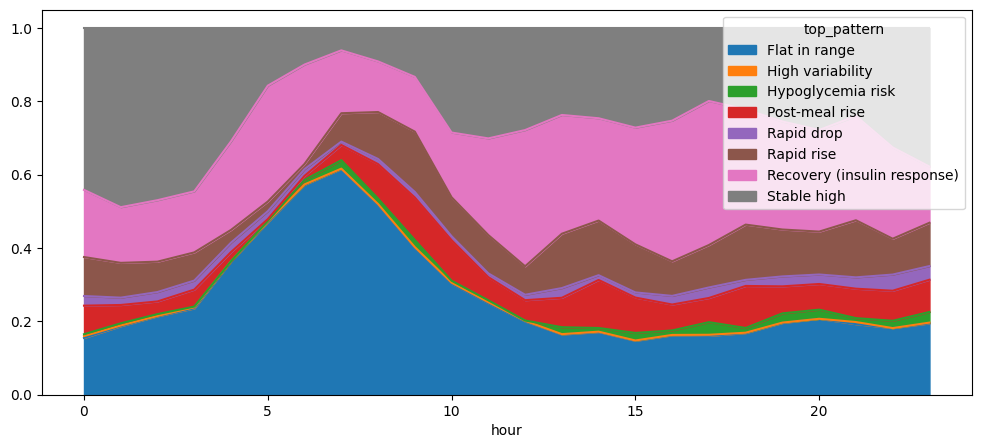

In [190]:
pd.crosstab(
    labeled["hour"],
    labeled["top_pattern"],
    normalize="index"
).plot(kind="area", figsize=(12,5))

In [191]:
def transition_matrix(df, conf_min=0.4):
    d = df[df["top_confidence"] >= conf_min].copy()
    d["next_pattern"] = d["top_pattern"].shift(-1)
    return pd.crosstab(d["top_pattern"], d["next_pattern"], normalize="index")

tm = transition_matrix(labeled)
display(tm)


next_pattern,Flat in range,High variability,Hypoglycemia risk,Post-meal rise,Rapid drop,Rapid rise,Recovery (insulin response),Stable high
top_pattern,,,,,,,,
Flat in range,0.871260,0.000000,0.001044,0.000000,0.006263,0.075505,0.017397,0.028532
High variability,0.020833,0.083333,0.000000,0.229167,0.145833,0.083333,0.041667,0.395833
Hypoglycemia risk,0.038095,0.000000,0.730159,0.000000,0.003175,0.225397,0.003175,0.000000
Post-meal rise,0.007874,0.000000,0.000000,0.422572,0.034121,0.194226,0.023622,0.317585
Rapid drop,0.011278,0.000000,0.003759,0.000000,0.317669,0.035714,0.578947,0.052632
Rapid rise,0.013002,0.016548,0.000788,0.082348,0.012214,0.750985,0.005516,0.118597
Recovery (insulin response),0.041176,0.000323,0.012595,0.000000,0.017439,0.021314,0.877442,0.029711
Stable high,0.013768,0.000000,0.000000,0.000000,0.042451,0.026159,0.086049,0.831574


In [192]:
def extract_episodes(df, pattern):
    m = df["top_pattern"] == pattern
    grp = (m != m.shift()).cumsum()
    eps = (
        df[m]
        .groupby(grp)
        .agg(
            start=("mg/dl", "first"),
            end=("mg/dl", "last"),
            duration_min=("mg/dl", lambda x: len(x)*5),
            max_glucose=("mg/dl", "max")
        )
    )
    return eps

post_meal_episodes = extract_episodes(labeled, "Post-meal rise")
display(post_meal_episodes.head())


,start,end,duration_min,max_glucose
top_pattern,,,,
2,280.0,318.0,25,318.0
4,325.0,325.0,5,325.0
6,267.0,269.0,10,269.0
8,310.0,310.0,5,310.0
10,351.0,360.0,10,360.0


In [193]:
labeled[labeled["top_pattern"] == "Stable high"]

,mg/dl,normal,carbInput,insulinCarbRatio,bgInput,recommended.carb,recommended.net,recommended.correction,insulinSensitivityFactor,targetBloodGlucose,insulinOnBoard,has_bolus_metadata_extended,basal_rate,has_basal_data,segment_id,slope_15min,slope_30min,mg/dl_diff,mg/dl_mean_30min,mg/dl_std_30min,relative_mg/dl,hour,dayofweek,is_night,minutes_since_last_bolus,bolus_active,minutes_since_last_meal,meal_active,patterns,top_pattern,top_confidence
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-13 21:05:00,310.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,-1.000000,0.400000,-11.0,320.166667,5.564770,-10.166667,21,1,0,0.0,1,0.0,1,"[{'pattern': 'Stable high', 'confidence': 0.19999999999999996}]",Stable high,0.200000
2021-07-13 21:10:00,308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,-1.066667,-0.333333,-2.0,318.500000,7.503333,-10.500000,21,1,0,0.0,1,0.0,1,"[{'pattern': 'Stable high', 'confidence': 0.33333333333333337}]",Stable high,0.333333
2021-07-13 21:15:00,317.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,-0.266667,-0.200000,9.0,317.500000,7.176350,-0.500000,21,1,0,0.0,1,0.0,1,"[{'pattern': 'Stable high', 'confidence': 0.6}]",Stable high,0.600000
2021-07-13 21:20:00,321.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.733333,-0.133333,4.0,316.833333,6.493587,4.166667,21,1,0,0.0,1,0.0,1,"[{'pattern': 'Stable high', 'confidence': 0.7333333333333334}]",Stable high,0.733333
2021-07-13 21:25:00,315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.466667,-0.300000,-6.0,315.333333,5.465040,-0.333333,21,1,0,0.0,1,0.0,1,"[{'pattern': 'Stable high', 'confidence': 0.4}]",Stable high,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-03 22:05:00,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30,-0.566667,-0.466667,-1.0,226.666667,6.088240,-6.666667,22,3,0,55.0,1,0.0,1,"[{'pattern': 'Stable high', 'confidence': 0.06666666666666665}]",Stable high,0.066667
2022-02-03 23:25:00,183.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30,0.933333,0.250000,4.5,174.416667,5.351791,8.583333,23,3,0,70.0,1,0.0,1,"[{'pattern': 'Stable high', 'confidence': 0.5}]",Stable high,0.500000
2022-02-03 23:30:00,187.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30,0.933333,0.466667,4.0,176.750000,7.305820,10.250000,23,3,0,75.0,1,0.0,1,"[{'pattern': 'Stable high', 'confidence': 0.06666666666666665}]",Stable high,0.066667


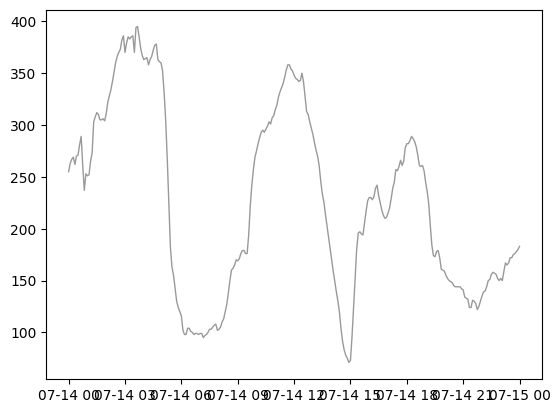

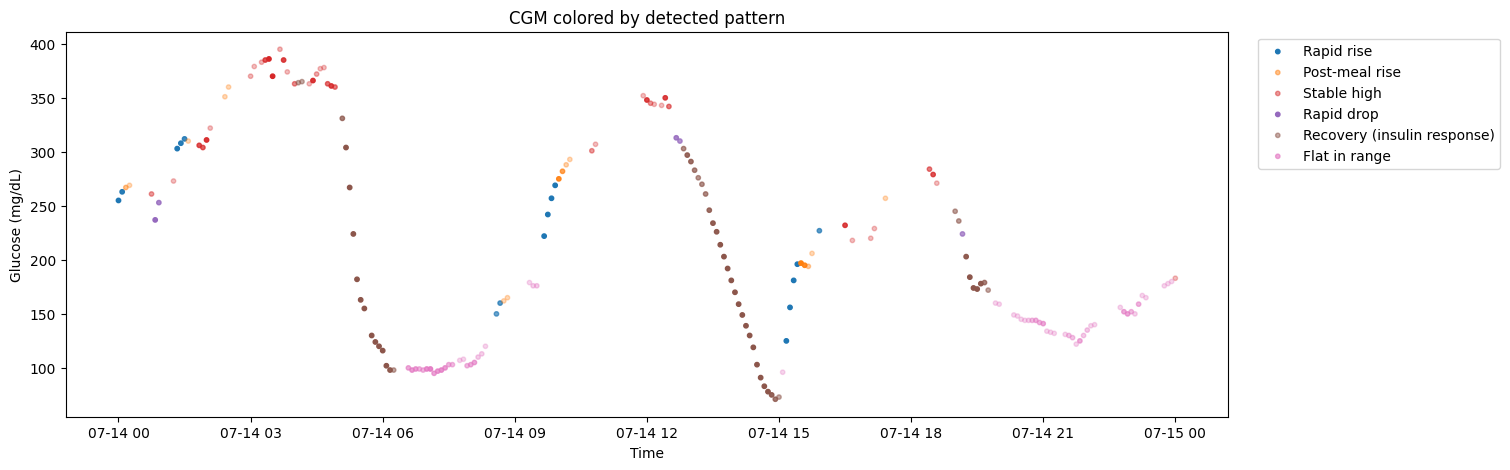

In [194]:
def plot_cgm_with_patterns(df, start=None, end=None):
    d = df.copy()
    if start:
        d = d[d.index >= pd.to_datetime(start)]
    if end:
        d = d[d.index <= pd.to_datetime(end)]

    patterns = d["top_pattern"].unique()
    cmap = dict(zip(patterns, plt.cm.tab10.colors[:len(patterns)]))

    plt.plot(
        d.index,
        d["mg/dl"],
        color="black",
        linewidth=1,
        alpha=0.4,
        label="Glucose"
    )

    plt.figure(figsize=(15,5))
    for p in patterns:
        m = d["top_pattern"] == p

        if not m.any():
            continue

        plt.scatter(
            d.index[m],
            d.loc[m, "mg/dl"],
            s=10,
            label=p,
            color=cmap.get(p, "gray"),
            alpha=d.loc[m, "top_confidence"].clip(0.3,1.0)
        )

    meal_times = d.index[d["carbInput"] > 0]
    plt.vlines(meal_times, ymin=40, ymax=400, color="orange", alpha=0.3)

    plt.ylabel("Glucose (mg/dL)")
    plt.xlabel("Time")
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.title("CGM colored by detected pattern")
    plt.show()

plot_cgm_with_patterns(labeled, start="2021-07-14", end="2021-07-15")

# Forecasting

In [195]:
def add_forecast_target(df, horizon_min=30):
    steps = horizon_min // 5
    out = df.copy()
    out[f"cgm_plus_{horizon_min}"] = out["mg/dl"].shift(-steps)
    return out

labeled = add_forecast_target(labeled, horizon_min=30)

FEATURE_COLS = [
    'mg/dl', 'mg/dl_diff', 'mg/dl_std_30min',
    "slope_15min", "slope_30min",
    # 'minutes_since_last_bolus',
    # 'minutes_since_last_meal',
    "relative_mg/dl",

    "meal_active",
    "bolus_active",
    "minutes_since_last_bolus",
    "minutes_since_last_meal",

    "hour",
    "is_night",
]

def pattern_confidence_matrix(df, pattern_names):
    """
    Creates one column per pattern with confidence (0 if absent).
    """
    out = pd.DataFrame(0.0, index=df.index, columns=pattern_names)

    for t, pats in df["patterns"].items():
        for p in pats:
            if p["pattern"] in out.columns:
                out.loc[t, p["pattern"]] = p["confidence"]
    return out

PATTERNS = [
    "Flat in range",
    "Stable high",
    "Rapid rise",
    "Post-meal rise",
    "Post-meal peak",
    "Recovery (insulin response)",
    "Rapid drop",
    "Hypoglycemia risk",
    "High variability",
]

pattern_feats = pattern_confidence_matrix(labeled, PATTERNS)
pattern_feats

,Flat in range,Stable high,Rapid rise,Post-meal rise,Post-meal peak,Recovery (insulin response),Rapid drop,Hypoglycemia risk,High variability
date,,,,,,,,,
2021-07-13 19:50:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-13 19:55:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-13 20:00:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-13 20:05:00,0.0,0.0,0.866667,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-13 20:10:00,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2022-02-03 23:35:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-03 23:40:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-03 23:45:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
df_model = pd.concat([labeled[FEATURE_COLS], pattern_feats], axis=1)
df_model["target"] = labeled["cgm_plus_30"]

print(df_model.isna().sum())
df_model = df_model.dropna()

mg/dl                          0
mg/dl_diff                     0
mg/dl_std_30min                0
slope_15min                    3
slope_30min                    6
relative_mg/dl                 0
meal_active                    0
bolus_active                   0
minutes_since_last_bolus       0
minutes_since_last_meal        0
hour                           0
is_night                       0
Flat in range                  0
Stable high                    0
Rapid rise                     0
Post-meal rise                 0
Post-meal peak                 0
Recovery (insulin response)    0
Rapid drop                     0
Hypoglycemia risk              0
High variability               0
target                         6
dtype: int64


In [ ]:
df_model = pd.concat([labeled[FEATURE_COLS], pattern_feats], axis=1)
df_model["target"] = labeled["cgm_plus_30"]

print(df_model.isna().sum())
df_model = df_model.dropna()

In [203]:
df_model

,mg/dl,mg/dl_diff,mg/dl_std_30min,slope_15min,slope_30min,relative_mg/dl,meal_active,bolus_active,minutes_since_last_bolus,minutes_since_last_meal,hour,is_night,Flat in range,Stable high,Rapid rise,Post-meal rise,Post-meal peak,Recovery (insulin response),Rapid drop,Hypoglycemia risk,High variability,target
date,,,,,,,,,,,,,,,,,,,,,,
2021-07-13 20:20:00,280.0,-2.0,22.684062,1.866667,2.233333,21.166667,1,1,0.0,0.0,20,0,0.000000,0.0,0.0,0.366667,0.0,0.0,0.0,0.0,0.0,325.0
2021-07-13 20:25:00,292.0,12.0,19.775406,1.333333,2.166667,22.333333,1,1,0.0,0.0,20,0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,324.0
2021-07-13 20:30:00,297.0,5.0,16.005207,1.000000,1.900000,17.833333,1,1,0.0,0.0,20,0,0.000000,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,321.0
2021-07-13 20:35:00,298.0,1.0,10.438710,1.200000,1.533333,11.166667,1,1,0.0,0.0,20,0,0.000000,0.0,0.0,0.016667,0.0,0.0,0.0,0.0,0.0,310.0
2021-07-13 20:40:00,318.0,20.0,13.736812,1.733333,1.533333,23.500000,1,1,0.0,0.0,20,0,0.000000,0.0,0.0,0.016667,0.0,0.0,0.0,0.0,0.0,308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-03 23:05:00,170.0,-3.0,6.530059,-0.600000,-0.550000,-8.083333,1,1,50.0,0.0,23,0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,188.5
2022-02-03 23:10:00,169.0,-1.0,5.695759,-0.433333,-0.600000,-6.083333,1,1,55.0,0.0,23,0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,188.5
2022-02-03 23:15:00,173.0,4.0,3.657185,0.000000,-0.366667,-0.250000,1,1,60.0,0.0,23,0,0.169142,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,188.5


In [197]:
split_time = df_model.index[int(len(df_model) * 0.8)]

train = df_model[df_model.index <= split_time]
test  = df_model[df_model.index > split_time]

X_train = train.drop(columns="target")
y_train = train["target"]

X_test  = test.drop(columns="target")
y_test  = test["target"]

In [198]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

model.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",300
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

In [199]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE (30 min):  {mae:.1f} mg/dL")
print(f"RMSE (30 min): {rmse:.1f} mg/dL")

MAE (30 min):  17.5 mg/dL
RMSE (30 min): 24.5 mg/dL


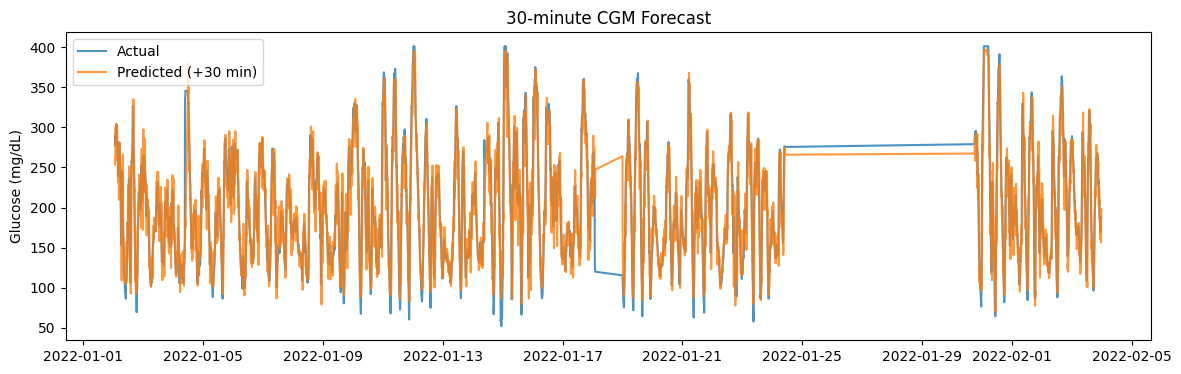

In [200]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(y_test.index, y_test.values, label="Actual", alpha=0.8)
plt.plot(y_test.index, y_pred, label="Predicted (+30 min)", alpha=0.8)
plt.legend()
plt.ylabel("Glucose (mg/dL)")
plt.title("30-minute CGM Forecast")
plt.show()

In [202]:
importances = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

display(importances)

mg/dl                          0.886193
mg/dl_diff                     0.052819
slope_30min                    0.024648
relative_mg/dl                 0.023950
hour                           0.004900
minutes_since_last_bolus       0.001902
slope_15min                    0.001330
mg/dl_std_30min                0.001198
minutes_since_last_meal        0.000992
Recovery (insulin response)    0.000489
Post-meal rise                 0.000387
is_night                       0.000332
Flat in range                  0.000248
High variability               0.000225
Hypoglycemia risk              0.000206
Rapid drop                     0.000174
Rapid rise                     0.000006
meal_active                    0.000000
bolus_active                   0.000000
Post-meal peak                 0.000000
Stable high                    0.000000
dtype: float64

In [ ]:
labeled = add_forecast_target(labeled, horizon_min=60)

# Normalization

If we don't normilize input, then UMAP will be biased. Features with larger ranges can dominate Euclidean distance calculations, leading to biased results.

In [104]:
from sklearn.preprocessing import StandardScaler

subject_33_for_clustering = subject_33_df_with_extra_features[[
    'mg/dl', 'mg/dl_diff', 'mg/dl_mean_30min', 'mg/dl_std_30min',
    'minutes_since_last_bolus',
    'minutes_since_last_meal',
    'normal', 'carbInput', 'insulinCarbRatio', 
    'minutes_since_last_bolus', 'bolus_active',
    'minutes_since_last_meal', 'meal_active',
    'hour', 'is_night'
]]

scaler = StandardScaler()

subject_33_normilized = pd.DataFrame(scaler.fit_transform(subject_33_for_clustering), columns=subject_33_for_clustering.columns, index=subject_33_for_clustering.index)

In [105]:
subject_33_normilized

,mg/dl,mg/dl_diff,mg/dl_mean_30min,mg/dl_std_30min,minutes_since_last_bolus,minutes_since_last_meal,normal,carbInput,insulinCarbRatio,minutes_since_last_bolus,bolus_active,minutes_since_last_meal,meal_active,hour,is_night
date,,,,,,,,,,,,,,,
2021-07-13 19:50:00,0.222143,0.000082,0.224980,-1.188267,-0.595688,-0.233022,-0.12926,-0.041175,-0.051799,-0.595688,-0.879698,-0.233022,-0.270457,1.094829,-0.648031
2021-07-13 19:55:00,0.412850,1.646466,0.321564,0.012593,-0.595688,-0.233022,-0.12926,-0.041175,-0.051799,-0.595688,-0.879698,-0.233022,-0.270457,1.094829,-0.648031
2021-07-13 20:00:00,0.589934,1.528868,0.413550,0.449728,-0.595688,-0.233022,-0.12926,-0.041175,-0.051799,-0.595688,-0.879698,-0.233022,-0.270457,1.239402,-0.648031
2021-07-13 20:05:00,0.753397,1.411269,0.500936,0.848794,-0.595688,-0.233022,-0.12926,-0.041175,-0.051799,-0.595688,-0.879698,-0.233022,-0.270457,1.239402,-0.648031
2021-07-13 20:10:00,1.025835,2.352060,0.608559,1.566457,-0.595688,-0.233022,-0.12926,-0.041175,-0.051799,-0.595688,-0.879698,-0.233022,-0.270457,1.239402,-0.648031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-03 23:35:00,-0.111594,0.176480,-0.232648,-0.244994,0.941809,-0.233022,-0.12926,-0.041175,-0.051799,0.941809,1.136754,-0.233022,-0.270457,1.673121,-0.648031
2022-02-03 23:40:00,-0.111594,0.000082,-0.187805,-0.427405,1.037903,-0.233022,-0.12926,-0.041175,-0.051799,1.037903,1.136754,-0.233022,-0.270457,1.673121,-0.648031
2022-02-03 23:45:00,-0.111594,0.000082,-0.152161,-0.690078,1.133997,-0.233022,-0.12926,-0.041175,-0.051799,1.133997,1.136754,-0.233022,-0.270457,1.673121,-0.648031


# Clustering

At this stage, our goal is to detect glucose behavior patterns for each individual, not to group different people together. Therefore, clustering should be performed separately for each person.

If we cluster all subjects at once, the algorithm will primarily separate people, not patterns. For example, some individuals have basal insulin data while others do not; UMAP would treat this difference as a major source of separation, even though it does not represent a glucose pattern. Similarly, individuals can have very different baseline glucose levels - one person may average around 120 mg/dL, while another may average closer to 160 mg/dL. When clustered together, these baseline differences dominate the embedding and result in clusters that reflect who the person is, rather than what their glucose is doing.

In [101]:
from umap import UMAP

umap_model = UMAP(n_components=2, random_state=42)
subject_33_umap = umap_model.fit_transform(subject_33_normilized)

c:\Users\nikit\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


What we god without added features like `has_basal_data`, `sequence_id` etc. that seems ambigious for clustering and detecting patterns.
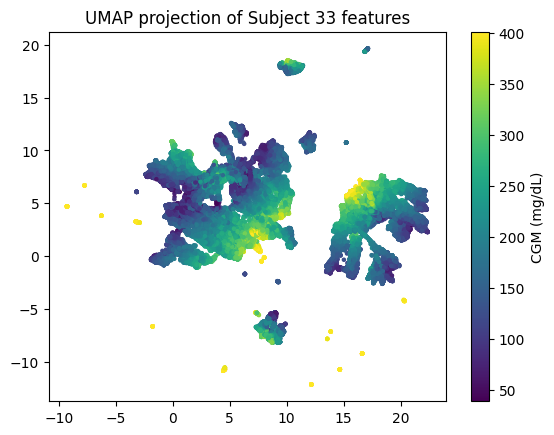

What we god with added features including `has_basal_data` etc. that seems ambigious for clustering and detecting patterns.
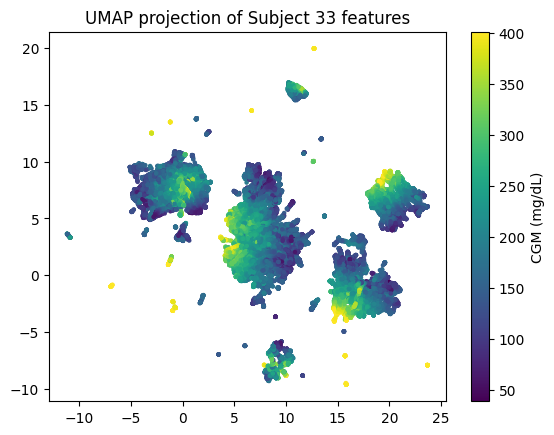

In [97]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.3, min_samples=10) # eps to tune
subject_33_clusters = dbscan.fit_predict(subject_33_umap)
subject_33_df_with_extra_features['UMAP1'] = subject_33_umap[:,0]
subject_33_df_with_extra_features['UMAP2'] = subject_33_umap[:,1]
subject_33_df_with_extra_features['Cluster'] = subject_33_clusters

C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\1138943970.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


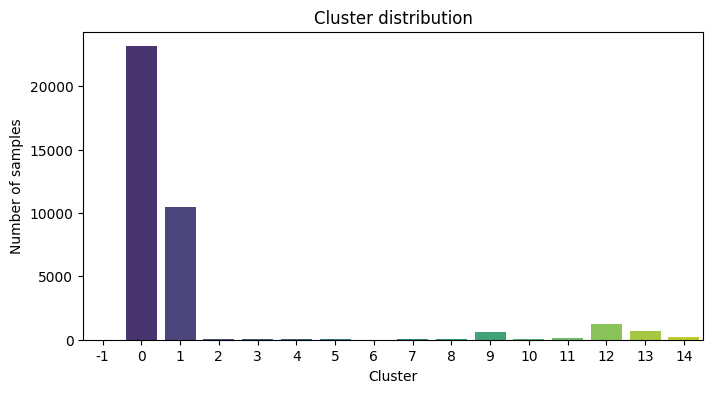

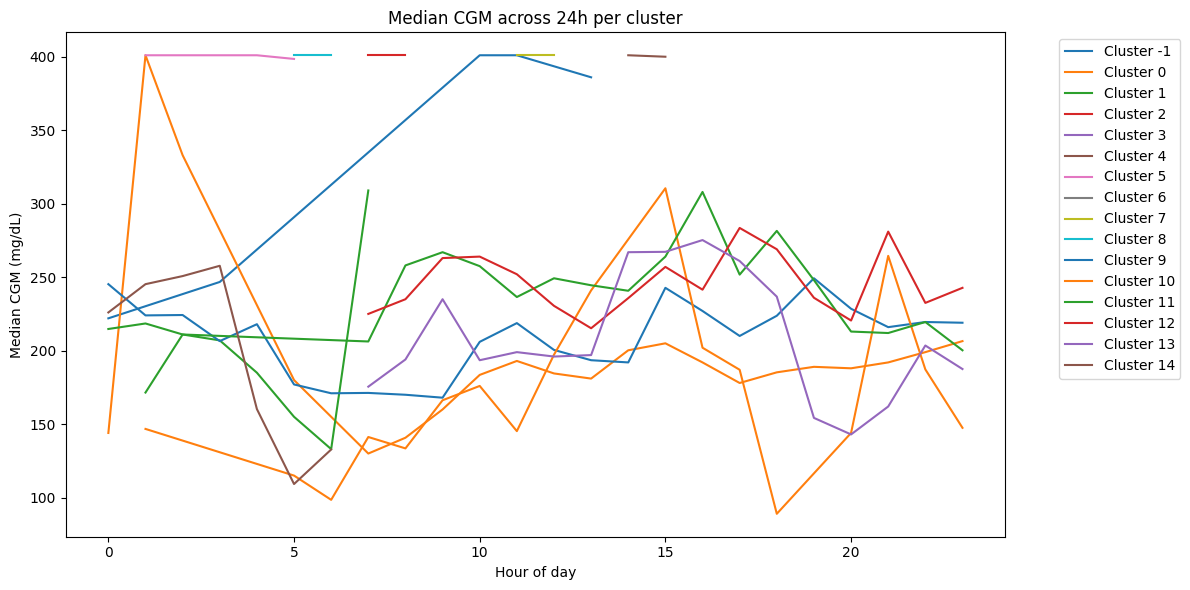

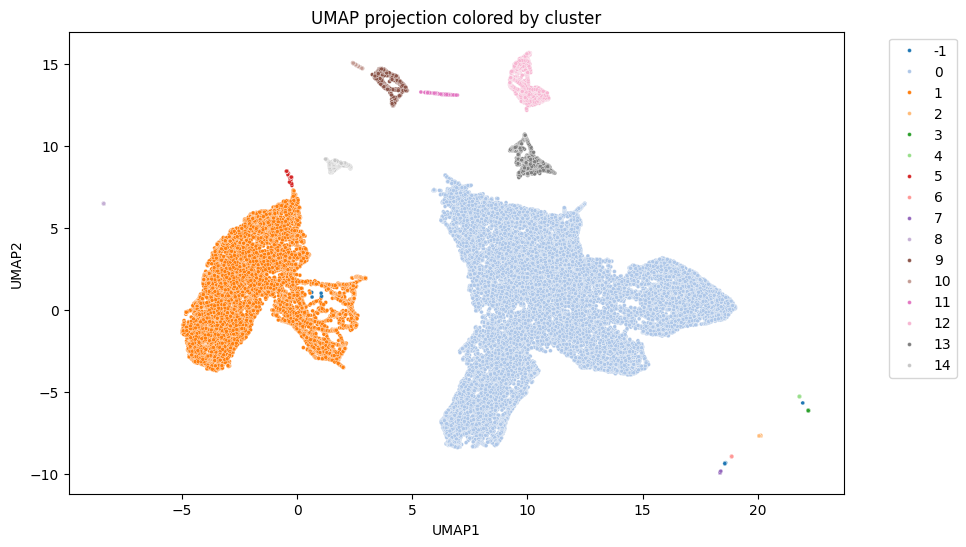

C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\1138943970.py:39: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subject_33_df_with_extra_features[subject_33_df_with_extra_features['Cluster']==cl]['mg/dl'], label=f"Cluster {cl}")
C:\Users\nikit\AppData\Local\Temp\ipykernel_3560\1138943970.py:39: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subject_33_df_with_extra_features[subject_33_df_with_extra_features['Cluster']==cl]['mg/dl'], label=f"Cluster {cl}")


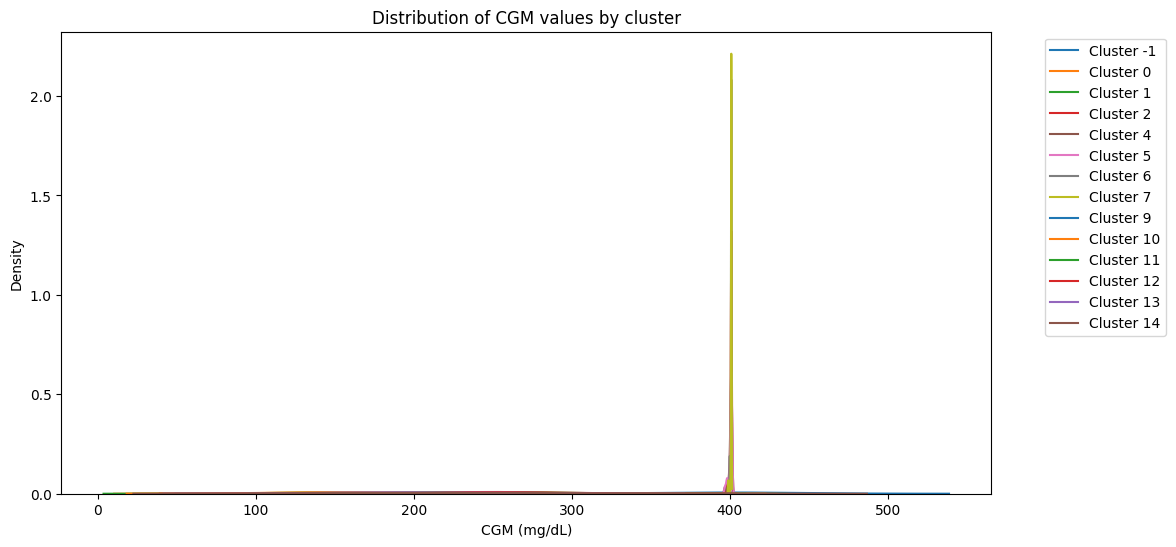

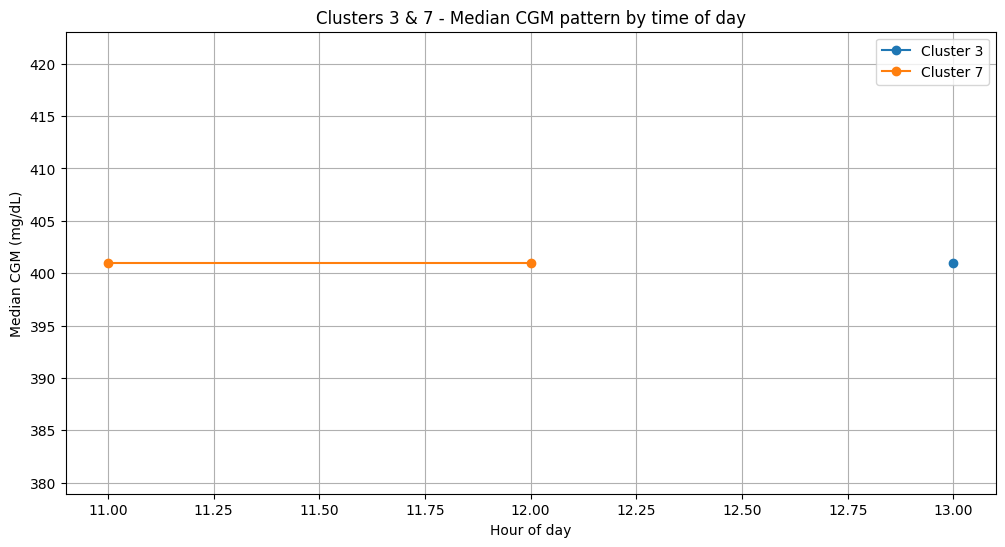

,mg/dl,normal,carbInput,insulinCarbRatio,bgInput,recommended.carb,recommended.net,recommended.correction,insulinSensitivityFactor,targetBloodGlucose,insulinOnBoard,has_bolus_metadata_extended,basal_rate,has_basal_data,segment_id,mg/dl_diff,mg/dl_mean_30min,mg/dl_std_30min,hour,dayofweek,is_night,is_day,minutes_since_last_bolus,bolus_active,minutes_since_last_meal,meal_active,UMAP1,UMAP2
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,401.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,1.0,0.0,0.0,24.0,0.00,401.00,0.00,11.0,4.0,0.0,1.0,47.5,1.0,0.0,0.0,18.580000,-9.35
0,181.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,1.0,0.0,0.0,18.0,-0.50,179.83,8.53,15.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,10.370000,0.66
1,188.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,1.0,0.0,0.0,18.0,-1.00,191.96,6.53,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.880000,0.95
2,401.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,1.0,0.0,0.0,6.0,0.00,401.00,0.00,7.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,20.139999,-7.67
3,401.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,1.0,0.0,0.0,8.0,0.00,401.00,0.00,13.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.200001,-6.15
4,401.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,1.0,0.0,0.0,8.0,0.00,401.00,0.00,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,21.809999,-5.29
5,401.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,1.0,0.0,0.0,24.0,0.00,401.00,0.00,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.310000,8.08
6,401.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,1.0,0.0,0.0,5.0,0.00,401.00,0.00,9.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,18.870001,-8.94
7,401.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,1.0,0.0,0.0,8.0,0.00,401.00,0.00,12.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,18.370001,-9.92


In [98]:
import seaborn as sns

# Cluster distribution
cluster_counts = subject_33_df_with_extra_features['Cluster'].value_counts().sort_index()
plt.figure(figsize=(8,4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
plt.title("Cluster distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of samples")
plt.show()

# Median CGM over 24-hour clock for each cluster
plt.figure(figsize=(12,6))
for cl in sorted(subject_33_df_with_extra_features['Cluster'].unique()):
    hourly_pattern = (
        subject_33_df_with_extra_features[subject_33_df_with_extra_features['Cluster'] == cl]
        .groupby('hour')['mg/dl']
        .median()
        .reset_index()
    )
    plt.plot(hourly_pattern['hour'], hourly_pattern['mg/dl'], label=f"Cluster {cl}")
plt.title("Median CGM across 24h per cluster")
plt.xlabel("Hour of day")
plt.ylabel("Median CGM (mg/dL)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# UMAP scatter by cluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=subject_33_df_with_extra_features, x='UMAP1', y='UMAP2', hue='Cluster', palette='tab20', s=8)
plt.title("UMAP projection colored by cluster")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# CGM histogram by cluster
plt.figure(figsize=(12,6))
for cl in sorted(subject_33_df_with_extra_features['Cluster'].unique()):
    sns.kdeplot(subject_33_df_with_extra_features[subject_33_df_with_extra_features['Cluster']==cl]['mg/dl'], label=f"Cluster {cl}")
plt.title("Distribution of CGM values by cluster")
plt.xlabel("CGM (mg/dL)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Focused visualization: clusters 3 and 7
focus_clusters = [3,7]
plt.figure(figsize=(12,6))
for cl in focus_clusters:
    hourly_pattern = (
        subject_33_df_with_extra_features[subject_33_df_with_extra_features['Cluster'] == cl]
        .groupby('hour')['mg/dl']
        .median()
        .reset_index()
    )
    plt.plot(hourly_pattern['hour'], hourly_pattern['mg/dl'], marker='o', label=f"Cluster {cl}")
plt.title("Clusters 3 & 7 - Median CGM pattern by time of day")
plt.xlabel("Hour of day")
plt.ylabel("Median CGM (mg/dL)")
plt.legend()
plt.grid(True)
plt.show()

# Cluster-level summary table
cluster_summary = subject_33_df_with_extra_features.groupby('Cluster').median().round(2)
display(cluster_summary)


In [108]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=8, random_state=42)
labels = gmm.fit_predict(subject_33_normilized)

subject_33_df_with_extra_features['GMM_Cluster'] = labels
subject_33_df_with_extra_features.groupby('GMM_Cluster').size()
subject_33_df_with_extra_features.groupby('GMM_Cluster').mean()


,mg/dl,normal,carbInput,insulinCarbRatio,bgInput,recommended.carb,recommended.net,recommended.correction,insulinSensitivityFactor,targetBloodGlucose,insulinOnBoard,has_bolus_metadata_extended,basal_rate,has_basal_data,segment_id,mg/dl_diff,mg/dl_mean_30min,mg/dl_std_30min,hour,dayofweek,is_night,is_day,minutes_since_last_bolus,bolus_active,minutes_since_last_meal,meal_active,UMAP1,UMAP2,Cluster
GMM_Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,218.907077,2.407418,0.000000,0.000000,0.000000,0.000000,2.408784,2.408784,20.891410,159.499190,2.801660,1.0,0.0,0.0,23.931929,4.330902,210.466279,10.630202,13.797407,2.936791,0.147488,0.816856,0.000000,0.000000,0.000000,0.0,4.114357,13.527643,8.753647
1,224.659474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,24.365687,-0.757016,225.050836,11.986852,16.345700,2.939733,0.000000,0.934131,36.047093,1.000000,0.000000,0.0,9.750150,1.468743,0.000757
2,191.801967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,8.534680,0.369512,190.891641,9.939919,14.412822,3.093064,0.000000,0.946230,0.000000,0.000000,0.000000,0.0,12.762952,1.267373,0.040725
3,190.658416,5.134248,40.920792,10.277228,183.336634,3.644653,5.183653,1.539000,20.792079,108.316832,2.383178,1.0,0.0,0.0,24.455446,9.277228,172.853960,15.826321,11.277228,2.990099,0.138614,0.831683,1.584158,0.029703,0.000000,0.0,3.410352,13.797161,9.029703
4,243.321739,2.281957,0.000000,0.000000,0.000000,0.000000,2.281957,2.281957,20.260870,159.634783,4.831600,1.0,0.0,0.0,23.547826,2.917391,236.709420,9.505729,12.573913,2.904348,0.017391,0.965217,0.000000,0.000000,101.043478,1.0,6.476249,13.154609,11.078261
5,124.246004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,23.675232,-0.106755,126.932627,8.222320,15.556291,3.084503,0.000000,0.926093,124.976159,1.000000,0.000000,0.0,7.957213,-5.766567,0.000265
6,203.343141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,13.014919,-1.055394,205.956601,8.072445,3.253902,3.127366,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,-2.540847,1.557009,1.054842
7,226.092399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,23.981590,1.656904,221.216457,10.253427,11.866527,3.024268,0.101255,0.869456,41.723849,1.000000,90.627615,1.0,9.304382,10.786680,11.175314
8,278.821839,0.227333,0.000000,0.000000,0.000000,0.000000,0.227333,0.227333,1.206897,9.195402,0.169920,1.0,0.0,0.0,14.011494,29.683908,219.435824,71.808435,10.540230,3.321839,0.344828,0.494253,1.091954,0.114943,0.000000,0.0,5.684125,6.622348,0.344828


In [111]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=24)
hdbscan_clusters = hdbscan.fit_predict(subject_33_umap)
subject_33_df_with_extra_features['HDBSCAN_Cluster'] = hdbscan_clusters
subject_33_df_with_extra_features.groupby('HDBSCAN_Cluster').mean()



c:\Users\nikit\miniconda3\Lib\site-packages\sklearn\cluster\_hdbscan\hdbscan.py:722: FutureWarning: The default value of `copy` will change from False to True in 1.10. Explicitly set a value for `copy` to silence this warning.
  warn(


,mg/dl,normal,carbInput,insulinCarbRatio,bgInput,recommended.carb,recommended.net,recommended.correction,insulinSensitivityFactor,targetBloodGlucose,insulinOnBoard,has_bolus_metadata_extended,basal_rate,has_basal_data,segment_id,mg/dl_diff,mg/dl_mean_30min,mg/dl_std_30min,hour,dayofweek,is_night,is_day,minutes_since_last_bolus,bolus_active,minutes_since_last_meal,meal_active,UMAP1,UMAP2,Cluster,GMM_Cluster
HDBSCAN_Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,204.802632,1.139532,0.905263,0.347368,4.989474,0.070158,1.139532,1.069374,10.105263,76.621053,1.328795,1.0,0.0,0.0,22.626316,2.750000,200.255263,10.021073,15.257895,2.905263,0.036842,0.910526,21.052632,0.447368,57.736842,0.457895,7.437045,12.211593,10.110526,3.394737
0,400.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,3.000000,-0.125000,400.951389,0.119072,7.000000,3.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,20.140177,-7.669880,2.000000,2.000000
1,401.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,10.787879,0.000000,401.000000,0.000000,11.818182,2.393939,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,18.367083,-9.920899,7.000000,2.000000
2,172.336207,7.063776,63.206897,10.379310,174.068966,5.869138,7.120672,1.251534,20.948276,110.862069,2.246328,1.0,0.0,0.0,24.482759,5.715517,160.839080,12.331633,12.362069,2.931034,0.068966,0.879310,0.000000,0.000000,0.000000,0.000000,2.544718,14.928941,10.000000,3.000000
3,229.308824,2.759118,2.558824,10.529412,211.176471,0.255882,2.563529,2.307647,21.323529,110.000000,2.826647,1.0,0.0,0.0,25.294118,16.544118,198.450980,23.120886,10.352941,2.882353,0.235294,0.764706,0.000000,0.000000,0.000000,0.000000,4.297977,12.864710,8.000000,3.000000
4,399.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,6.104167,-0.125000,399.906250,0.251197,13.479167,1.958333,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,21.383926,-4.997255,3.187500,2.000000
5,400.469388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,19.775510,-0.224490,400.680272,0.358862,3.142857,1.897959,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.346424,8.144640,5.000000,6.000000
6,401.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,9.800000,0.000000,400.933333,0.111555,5.433333,3.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.128508,6.484835,7.766667,6.000000
7,188.092496,0.000000,0.020044,0.001156,0.028236,0.000546,0.000804,0.000257,0.002409,0.010600,0.000449,1.0,0.0,0.0,24.114580,-0.516125,189.319261,10.600722,16.058977,2.991905,0.000000,0.931194,68.391154,1.000000,0.000000,0.000000,9.099894,-1.165038,0.000482,2.455334


In [113]:
subject_33

,mg/dl,mg/dl_diff,mg/dl_mean_30min,mg/dl_std_30min,minutes_since_last_bolus,minutes_since_last_meal,normal,carbInput,insulinCarbRatio,minutes_since_last_bolus,bolus_active,minutes_since_last_meal,meal_active,hour,is_night
date,,,,,,,,,,,,,,,
2021-07-13 19:50:00,0.222143,0.000082,0.224980,-1.188267,-0.595688,-0.233022,-0.12926,-0.041175,-0.051799,-0.595688,-0.879698,-0.233022,-0.270457,1.094829,-0.648031
2021-07-13 19:55:00,0.412850,1.646466,0.321564,0.012593,-0.595688,-0.233022,-0.12926,-0.041175,-0.051799,-0.595688,-0.879698,-0.233022,-0.270457,1.094829,-0.648031
2021-07-13 20:00:00,0.589934,1.528868,0.413550,0.449728,-0.595688,-0.233022,-0.12926,-0.041175,-0.051799,-0.595688,-0.879698,-0.233022,-0.270457,1.239402,-0.648031
2021-07-13 20:05:00,0.753397,1.411269,0.500936,0.848794,-0.595688,-0.233022,-0.12926,-0.041175,-0.051799,-0.595688,-0.879698,-0.233022,-0.270457,1.239402,-0.648031
2021-07-13 20:10:00,1.025835,2.352060,0.608559,1.566457,-0.595688,-0.233022,-0.12926,-0.041175,-0.051799,-0.595688,-0.879698,-0.233022,-0.270457,1.239402,-0.648031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-03 23:35:00,-0.111594,0.176480,-0.232648,-0.244994,0.941809,-0.233022,-0.12926,-0.041175,-0.051799,0.941809,1.136754,-0.233022,-0.270457,1.673121,-0.648031
2022-02-03 23:40:00,-0.111594,0.000082,-0.187805,-0.427405,1.037903,-0.233022,-0.12926,-0.041175,-0.051799,1.037903,1.136754,-0.233022,-0.270457,1.673121,-0.648031
2022-02-03 23:45:00,-0.111594,0.000082,-0.152161,-0.690078,1.133997,-0.233022,-0.12926,-0.041175,-0.051799,1.133997,1.136754,-0.233022,-0.270457,1.673121,-0.648031
